# Getting Started

## Colab Notebook Runtimes

* Click on "Change runtime type"

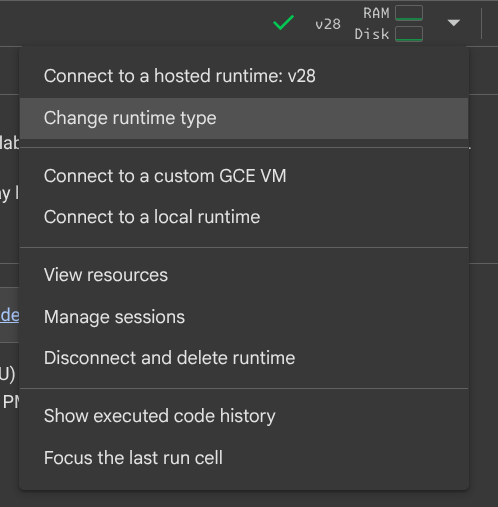

* Choose the runtime type to be "Julia" and choose your favorite accelerator (preferably "TPU" since we will try some multi-device experiments)

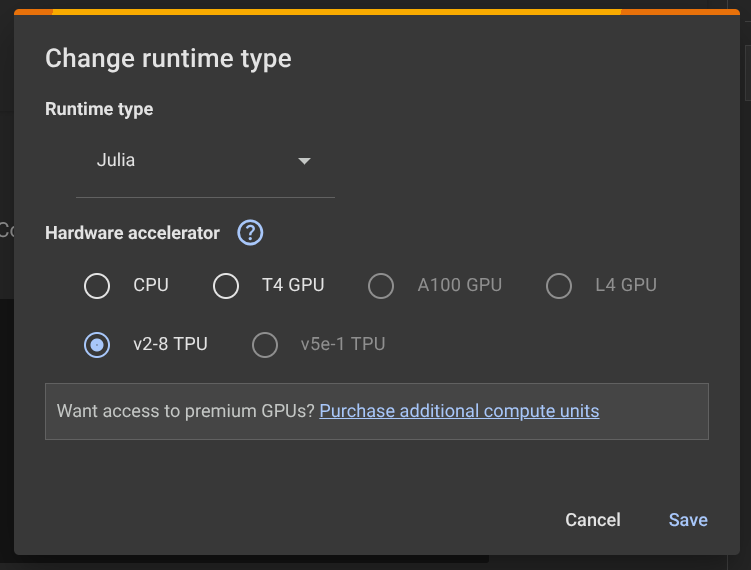


## Setting up Julia on your Local Machines

> Strongly recommended to use Colab for this workshop, since it will make troubleshooting easier

* For Windows users, Reactant doesn't yet support Windows. Install Julia in WSL instead.

* Follow instructions on the JuliaLang website to download Julia (https://julialang.org/install/#installing_julia). Install version 1.11 using juliaup. For most users this will be:

```sh
curl -fsSL https://install.julialang.org | sh
juliaup add 1.11
```

After installation `julia` can be started using `julia +1.11` (`+1.11` indicates the version of Julia to start)

* Download this Colab notebook as a `.ipynb` file.

* Follow instructions at https://github.com/JuliaLang/IJulia.jl to setup Jupyter notebook support with Julia. Finally open the notebook you downloaded

In [1]:
const IN_COLAB = any(Base.Fix1(occursin, "COLAB"), keys(ENV))
@info IN_COLAB

const IS_COLAB_GPU = !isempty(get(ENV, "COLAB_GPU", ""))
@info IS_COLAB_GPU

const IS_COLAB_TPU = !isempty(get(ENV, "COLAB_TPU_1VM", ""))
@info IS_COLAB_TPU

ENV["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

[ Info: false
[ Info: false
[ Info: false


"--xla_force_host_platform_device_count=8"

# Packages

Colab comes pre-installed with most of the packages that we need. If you are not using Colab, all the packages that we will use today can be installed with the following cell:

In [2]:
import Pkg

IN_COLAB || Pkg.activate(".")

  Activating project at `/mnt/software/lux/LuxReactantCSAILAlliances2025`


In [ ]:
Pkg.update()
Pkg.add([
    "Preferences",
    "Optimisers",
    "BenchmarkTools",
    "Lux",
    "Reactant",
    "Random",
    "Statistics",
    "Enzyme",
    "MLUtils",
    "ConcreteStructs",
    "Printf",
    "CairoMakie",
    "CUDA",
    "PythonCall",
    "FFTW",
    "OnlineStats",
])
Pkg.status()

import Preferences
# Don't worry about this line, we are using a new XLA runtime for distributed
# workloads. This will be the default from the next major release of Reactant
Preferences.set_preferences!("Reactant", "xla_runtime" => "IFRT")

    Updating registry at `/mnt/.julia/registries/General.toml`
  No Changes to `/mnt/software/lux/LuxReactantCSAILAlliances2025/Project.toml`
  No Changes to `/mnt/software/lux/LuxReactantCSAILAlliances2025/Manifest.toml`
Precompiling project...
  36190.5 ms  ✓ Reactant
   7377.6 ms  ✓ Reactant → ReactantPythonCallExt
  2 dependencies successfully precompiled in 45 seconds. 485 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version. Otherwise, loading dependents of this package may trigger further precompilation to work with the unexpected version.
  2 dependencies had output during precompilation:
┌ Reactant → ReactantPythonCallExt
│      CondaPkg Found dependencies: /mnt/.julia/packages/PythonCall/WMWY0/CondaPkg.toml
│      CondaPkg Found dependencies: /mnt/.julia/dev/Reactant/CondaPkg.toml
│      CondaPkg Resolving changes
│               ~ jax (pip)
│               + ml-dtypes (pip)
│      CondaPkg Initia

stmt = :($(Expr(:method, :(Base.getproperty(Reactant, :REACTANT_METHOD_TABLE)), %J16, CodeInfo(
    @ /mnt/.julia/dev/Reactant/src/Overlay.jl:7 within `none`
1 ─ %1 = var"#(overlay (. Reactant (inert REACTANT_METHOD_TABLE)) (. Compiler (inert compile)))#271"
│   %2 = Core.NamedTuple()
│   %3 = Base.pairs(%2)
│   %4 = (%1)(%3, #self#, f, args)
└──      return %4
))))


    Updating `/mnt/software/lux/LuxReactantCSAILAlliances2025/Project.toml`┌ Error: Error watching manifest
│   exception =
│    name Expr not recognized
│    Stacktrace:
│     [1] error(::String, ::Type, ::String)
│       @ Base ./error.jl:44
│     [2] direct_links!(cl::LoweredCodeUtils.CodeLinks, src::Core.CodeInfo)
│       @ LoweredCodeUtils /mnt/.julia/packages/LoweredCodeUtils/KmhBQ/src/codeedges.jl:265
└ @ Revise /mnt/.julia/packages/Revise/03e6k/src/pkgs.jl:498

  [a15396b6] + OnlineStats v1.7.1
  [3c362404] ~ Reactant v0.2.83 `/mnt/.julia/dev/Reactant` ⇒ v0.2.83
    Updating `/mnt/software/lux/LuxReactantCSAILAlliances2025/Manifest.toml`
  [a15396b6] + OnlineStats v1.7.1
  [925886fa] + OnlineStatsBase v1.7.1
  [3c362404] ~ Reactant v0.2.83 `/mnt/.julia/dev/Reactant` ⇒ v0.2.83
  [3cdcf5f2] + RecipesBase v1.3.4
Precompiling project...
    344.4 ms  ✓ IntervalSets → IntervalSetsRecipesBaseExt
    573.5 ms  ✓ IntervalArithmetic → IntervalArithmeticRecipesBaseExt
    691.8 ms  ✓ Onl

In [3]:
using Lux, Reactant, Random, Statistics, Enzyme, MLUtils,
    ConcreteStructs, Printf, Optimisers, CairoMakie,
    BenchmarkTools, CUDA, FFTW, OnlineStats

# Quick Introduction to Julia

We will only cover the basics. For more detailed tutorials checkout the following resources:

1. https://lux.csail.mit.edu/stable/tutorials/beginner/1_Basics
2. https://jump.dev/JuMP.jl/stable/tutorials/getting_started/getting_started_with_julia/#Getting-started-with-Julia
3. https://www.wias-berlin.de/people/fuhrmann/SciComp-WS2122/week2/#week_2_julia_concepts


## Array Programming

In [1]:
x = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

In [5]:
x = rand(Float32, 5, 3, 2)

5×3×2 Array{Float32, 3}:
[:, :, 1] =
 0.753766  0.845293   0.278672
 0.378499  0.831972   0.392877
 0.686249  0.777901   0.420936
 0.484174  0.126133   0.429056
 0.949524  0.0374692  0.275967

[:, :, 2] =
 0.156426  0.679647  0.999261
 0.490603  0.515709  0.104369
 0.433189  0.197382  0.938931
 0.2995    0.89877   0.429129
 0.299711  0.607704  0.723727

In [6]:
x[0, 0, 1] # Julia is 1-indexed

LoadError: BoundsError: attempt to access 5×3×2 Array{Float32, 3} at index [0, 0, 1]

In [8]:
x[1, 2] # Either linear indexing or specify full cartesian index

LoadError: BoundsError: attempt to access 5×3×2 Array{Float32, 3} at index [1, 2]

In [10]:
x[1, 2, :] # equivalent to partial indexing in python

2-element Vector{Float32}:
 0.84529275
 0.67964697

In [12]:
x .+ 1  # .(fn) broadcasts the function fn

5×3×2 Array{Float32, 3}:
[:, :, 1] =
 1.75377  1.84529  1.27867
 1.3785   1.83197  1.39288
 1.68625  1.7779   1.42094
 1.48417  1.12613  1.42906
 1.94952  1.03747  1.27597

[:, :, 2] =
 1.15643  1.67965  1.99926
 1.4906   1.51571  1.10437
 1.43319  1.19738  1.93893
 1.2995   1.89877  1.42913
 1.29971  1.6077   1.72373

In [13]:
fn(x) = x ^ 2

fn (generic function with 1 method)

In [14]:
fn.(x)

5×3×2 Array{Float32, 3}:
[:, :, 1] =
 0.568163  0.71452     0.0776579
 0.143261  0.692177    0.154352
 0.470938  0.60513     0.177187
 0.234425  0.0159095   0.184089
 0.901597  0.00140394  0.0761576

[:, :, 2] =
 0.0244691  0.46192    0.998522
 0.240691   0.265956   0.0108928
 0.187652   0.0389595  0.881592
 0.0897003  0.807787   0.184152
 0.0898269  0.369304   0.523781

You can make the full operation not allocate by pre-allocating the buffer (as you should for all performance critical code)

In [23]:
x = rand(Float32, 100_000);
y = similar(x);
@. y = fn(x); # @. allows you to chain broadcast

In [24]:
@benchmark (@. $y = fn($x))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  13.745 μs … 90.379 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     14.453 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.911 μs ±  2.513 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▅▇█▄▃▂▁                                                    ▂
  ██████████▇▇▆▆▆▅▆▄▄▄▅▆▆▇▇▇▇▇▆▇▆▇▇▆▇▆▆▇▇▇▆▇▆▅▄▅▅▄▄▃▃▃▅▁▅▄▄▄▅ █
  13.7 μs      Histogram: log(frequency) by time      27.1 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

Loops are actually fast in julia

In [25]:
@inbounds function square_function!(y, x)
    @simd ivdep for i in eachindex(x)
        y[i] = x[i] ^ 2
    end
end

@benchmark square_function!($y, $x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  12.907 μs … 90.906 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     14.434 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.838 μs ±  2.473 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▅▅▄█▅▂▂▁                                                ▁
  ▆▄▁▅█████████▆▆▅▅▅▅▅▅▅▆▆▆▆▇▅▅▇▇▇▆▇▆▆▇▆▆▅▆▆▇▇▆▆▆▆▆▆▆▅▄▅▆▄▅▅▄ █
  12.9 μs      Histogram: log(frequency) by time      24.9 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

Still using Array based programming (non-looped code) is good for automatic GPU-ification of the those code using CUDA.jl, AMDGPU.jl, OneAPI.jl, OpenCL.jl, and Metal.jl.

We won't be using these packages for todays workshop. Instead we will automatically leverage XLA's runtime for these.

## Type System in Julia

Credits: https://www.wias-berlin.de/people/fuhrmann/SciComp-WS2122/assets/nb04-julia-types.html

* Julia is a strongly typed language

* Knowledge about the layout of a value in memory is encoded in its type

* Prerequisite for performance

* There are concrete types and abstract types

In [28]:
@show typeof(10)
@show typeof(10.0)
@show typeof(10 + 1im)

typeof(10) = Int64
typeof(10.0) = Float64
typeof(10 + 1im) = Complex{Int64}


Complex{Int64}

Structs are used to defined custom types (by default these are immutable, but can be marked mutable using `mutable struct`)

In [32]:
abstract type AbstractCustomColor end

struct CustomColor{T} <: AbstractCustomColor
    r::T
    g::T
    b::T
end

struct BadCustomColor{T} <: AbstractCustomColor
    r::T
    g::T
    b
end

In [33]:
CustomColor(1.0, 2.0, 3.0), BadCustomColor(1.0, 2.0, 3.0)

(CustomColor{Float64}(1.0, 2.0, 3.0), BadCustomColor{Float64}(1.0, 2.0, 3.0))

### The power of multiple dispatch

* Multiple dispatch is one of the defining features of Julia

* Combined with the the hierarchical type system it allows for powerful generic program design

* New datatypes (different kinds of numbers, differently stored arrays/matrices) work with existing code once they implement the same interface as existent ones.

* Distinct from method overloading

We will come back to this later. This is what enables Reactant to work with pre-existing codebases

## Julia's Just-In-Time Compiler (aka How it gets its Performance)

Credits: https://www.wias-berlin.de/people/fuhrmann/SciComp-WS2122/assets/nb05-julia-jit.html

* Just-in-time compilation is another feature setting Julia apart, as it was developed with this possibility in mind.

* Julia uses the tools from the The LLVM Compiler Infrastructure Project to organize on-the-fly compilation of Julia code to machine code

* Tradeoff: startup time for code execution in interactive situations

* Multiple steps: Parse the code, analyze data types etc.

* Intermediate results can be inspected using a number of macros (blue color in the diagram below)

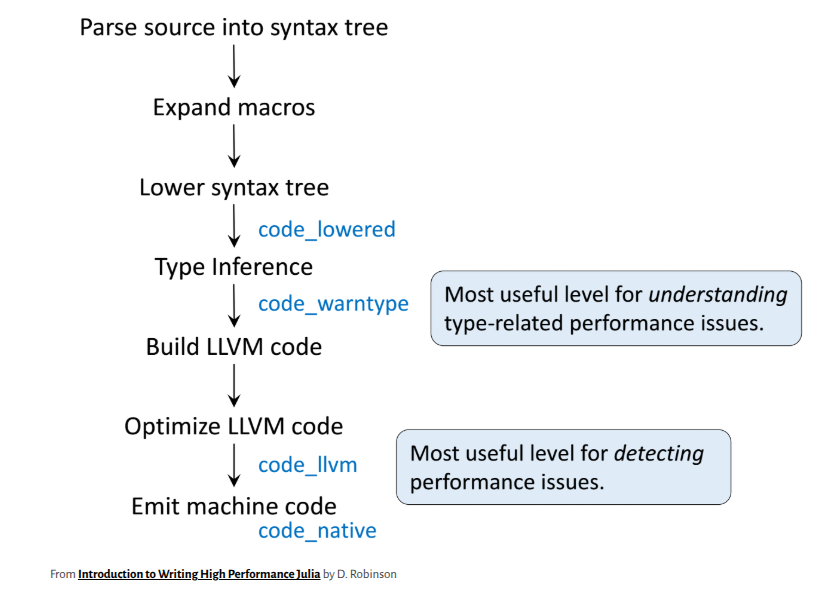

In [38]:
g(x, y) = x + y

g (generic function with 1 method)

In [25]:
@show g(2, 3)
@show g(2.0, 3.0)
@show g(2, 3.0)
nothing

g(2, 3) = 5
g(2.0, 3.0) = 5.0
g(2, 3.0) = 5.0


In [29]:
@code_typed g(2, 3)

CodeInfo(
1 ─ %1 = Base.add_int(x, y)::Int64
└──      return %1
) => Int64

In [30]:
@code_typed g(2.0, 3.0)

CodeInfo(
1 ─ %1 = Base.add_float(x, y)::Float64
└──      return %1
) => Float64

In [31]:
@code_typed g(2, 3.0)

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, x)::Float64
│   %2 = Base.add_float(%1, y)::Float64
└──      return %2
) => Float64

In [36]:
@code_llvm g(2, 3)

;  @ In[20]:1 within `g`
define i64 @julia_g_4158(i64 signext %0, i64 signext %1) #0 {
top:
;  @ In[20]:2 within `g`
; ┌ @ int.jl:87 within `+`
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [37]:
@code_llvm g(2.0, 3.0)

;  @ In[20]:1 within `g`
define double @julia_g_4176(double %0, double %1) #0 {
top:
;  @ In[20]:2 within `g`
; ┌ @ float.jl:409 within `+`
   %2 = fadd double %0, %1
; └
  ret double %2
}


In [34]:
function Base.:+(a::AbstractCustomColor, b::AbstractCustomColor)
    return (a.r + b.r, a.g + b.g, a.b + b.b)
end

In [35]:
color1 = CustomColor(1.0, 2.0, 3.0)
@code_warntype color1 + color1

MethodInstance for +(::CustomColor{Float64}, ::CustomColor{Float64})
  from +(a::AbstractCustomColor, b::AbstractCustomColor) @ Main In[34]:1
Arguments
  #self#::Core.Const(+)
  a::CustomColor{Float64}
  b::CustomColor{Float64}
Body::Tuple{Float64, Float64, Float64}
1 ─ %1  = Base.getproperty(a, :r)::Float64
│   %2  = Base.getproperty(b, :r)::Float64
│   %3  = (%1 + %2)::Float64
│   %4  = Base.getproperty(a, :g)::Float64
│   %5  = Base.getproperty(b, :g)::Float64
│   %6  = (%4 + %5)::Float64
│   %7  = Base.getproperty(a, :b)::Float64
│   %8  = Base.getproperty(b, :b)::Float64
│   %9  = (%7 + %8)::Float64
│   %10 = Core.tuple(%3, %6, %9)::Tuple{Float64, Float64, Float64}
└──       return %10



In [36]:
color2 = BadCustomColor(1.0, 2.0, 3.0)
@code_warntype color2 + color2

MethodInstance for +(::BadCustomColor{Float64}, ::BadCustomColor{Float64})
  from +(a::AbstractCustomColor, b::AbstractCustomColor) @ Main In[34]:1
Arguments
  #self#::Core.Const(+)
  a::BadCustomColor{Float64}
  b::BadCustomColor{Float64}
Body::Tuple{Float64, Float64, Any}
1 ─ %1  = Base.getproperty(a, :r)::Float64
│   %2  = Base.getproperty(b, :r)::Float64
│   %3  = (%1 + %2)::Float64
│   %4  = Base.getproperty(a, :g)::Float64
│   %5  = Base.getproperty(b, :g)::Float64
│   %6  = (%4 + %5)::Float64
│   %7  = Base.getproperty(a, :b)::Any
│   %8  = Base.getproperty(b, :b)::Any
│   %9  = (%7 + %8)::Any
│   %10 = Core.tuple(%3, %6, %9)::Tuple{Float64, Float64, Any}
└──       return %10



In [38]:
@code_warntype color1 + color2

MethodInstance for +(::CustomColor{Float64}, ::BadCustomColor{Float64})
  from +(a::AbstractCustomColor, b::AbstractCustomColor) @ Main In[34]:1
Arguments
  #self#::Core.Const(+)
  a::CustomColor{Float64}
  b::BadCustomColor{Float64}
Body::Tuple{Float64, Float64, Any}
1 ─ %1  = Base.getproperty(a, :r)::Float64
│   %2  = Base.getproperty(b, :r)::Float64
│   %3  = (%1 + %2)::Float64
│   %4  = Base.getproperty(a, :g)::Float64
│   %5  = Base.getproperty(b, :g)::Float64
│   %6  = (%4 + %5)::Float64
│   %7  = Base.getproperty(a, :b)::Float64
│   %8  = Base.getproperty(b, :b)::Any
│   %9  = (%7 + %8)::Any
│   %10 = Core.tuple(%3, %6, %9)::Tuple{Float64, Float64, Any}
└──       return %10



# Deep Learning in Julia using Lux

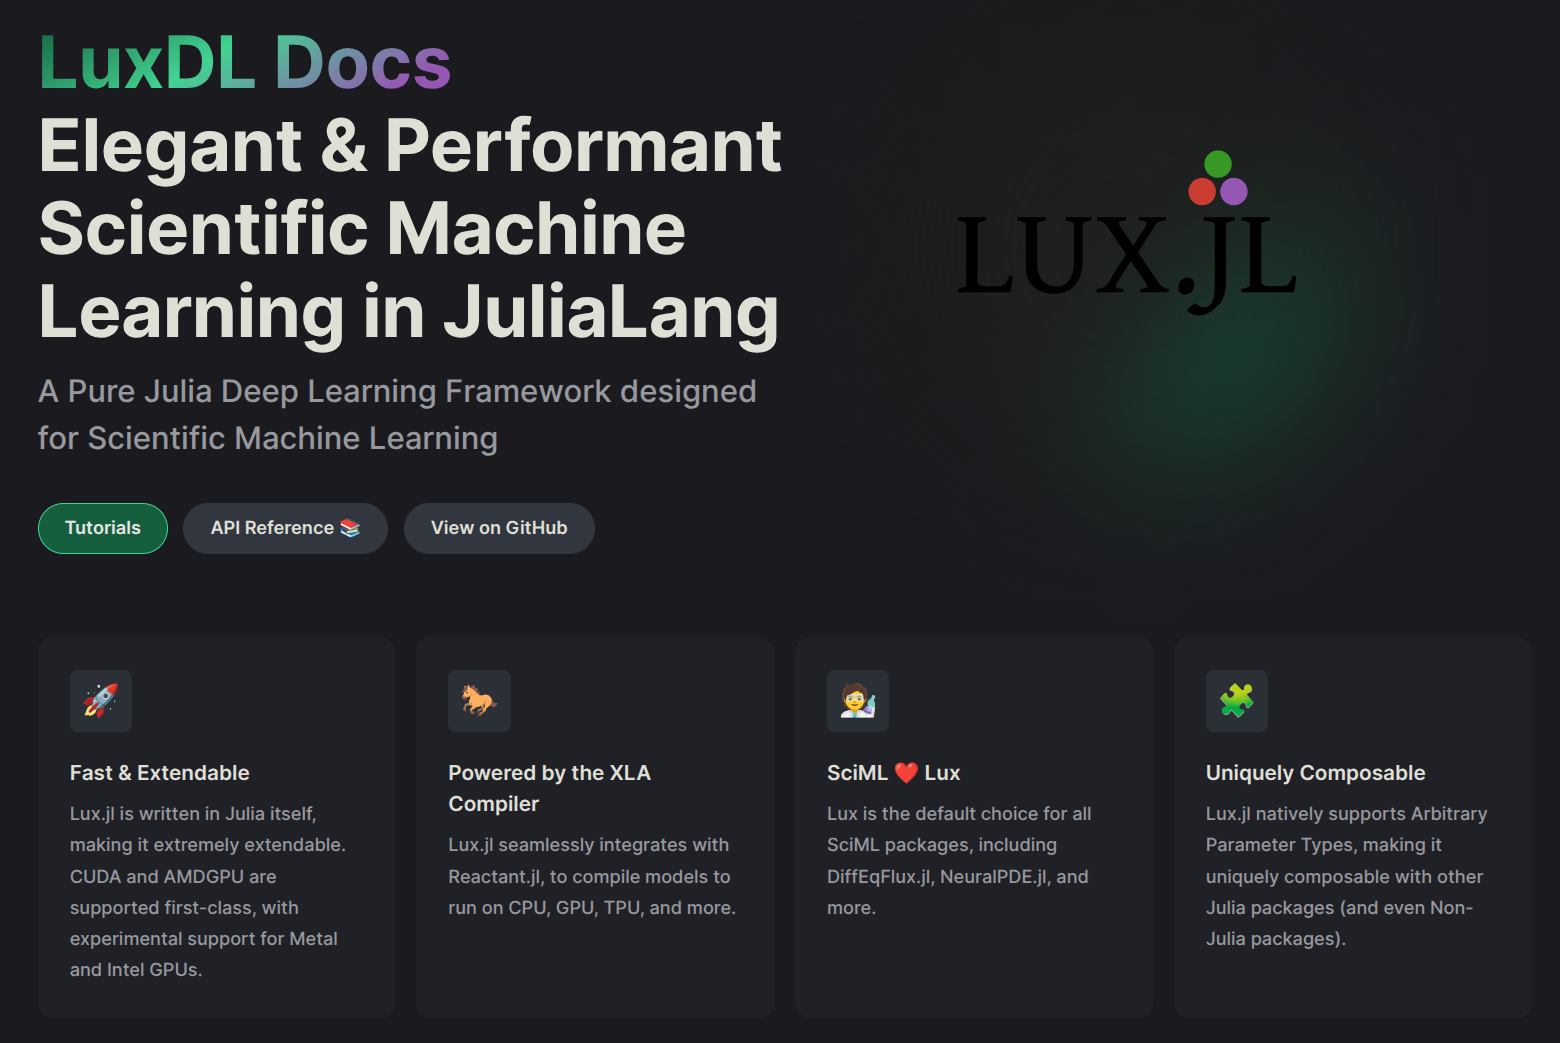

Initially designed to meet the challenges of Scientific Machine Learning, which mostly involves smaller neural networks. However, lately with some our fancy advancements in compiler optimizations, we can now train larger models just as fast as more mainstream frameworks like Jax.

### Guiding Principles

- Easy to use with built-in layers
- Easy to implement custom layers with good performance
- Automatic vectorization
- Fast automatic differentiation (forward & reverse mode)

In [4]:
mlp = Chain(
    Dense(2 => 32, relu),
    Dense(32 => 2)
)

Chain(
    layer_1 = Dense(2 => 32, relu),     # 96 parameters
    layer_2 = Dense(32 => 2),           # 66 parameters
)         # Total: 162 parameters,
          #        plus 0 states.

In [5]:
dump(mlp)  # doesn't actually store any parameters

Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}
  layers: @NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}
    layer_1: Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}
      activation: relu (function of type typeof(relu))
      in_dims: Int64 2
      out_dims: Int64 32
      init_weight: Nothing nothing
      init_bias: Nothing nothing
      use_bias: Static.True static(true)
    layer_2: Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}
      activation: identity (function of type typeof(identity))
      in_dims: Int64 32
      out_dims: Int64 2
      init_weight: Nothing nothing
      init_bias: Nothing nothing
      use_bias: Static.True static(true)
  name: Nothing nothing


In [6]:
ps, st = Lux.setup(Random.default_rng(), mlp)

((layer_1 = (weight = Float32[-0.043164603 -0.8606784; 2.134517 -0.9421078; … ; 2.0071166 -0.12955892; 1.4206648 0.6941631], bias = Float32[-0.21292579, 0.28243876, -0.49671435, -0.23649658, 0.19291708, 0.6881958, 0.47697815, -0.28187114, -0.34620973, -0.087747544  …  -0.36917326, 0.35355717, 0.36909276, 0.05295625, 0.4136597, 0.5801785, -0.0043090936, 0.37355122, 0.06845331, 0.5321333]), layer_2 = (weight = Float32[-0.29701632 -0.10453728 … -0.08724832 -0.17210661; -0.25437 0.13991952 … -0.191365 0.15307133], bias = Float32[0.15764058, 0.060150698])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

`Lux.setup` gives us the parameters and states (non-trainable values like batchnorm running statistics)

In [7]:
x = rand(Float32, 2, 48) # Last dimension is the batch-dimension --> Julia is Column-Major slicing is fastest along the columns

2×48 Matrix{Float32}:
 0.0409475  0.299222  0.827485  0.465727  …  0.326292  0.498435  0.033082
 0.678479   0.416858  0.362659  0.227759     0.585002  0.25702   0.168715

In [8]:
mlp(x, ps, st) # gives the output, new_state variables

(Float32[1.2841574 1.3178301 … 1.4087877 0.5712654; 0.09284958 0.101523414 … 0.011524759 0.19377403], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

### Example Usecase: Physics Informed Neural Network

We will be using Reactant in this example, but don't worry we will get into the weeds of reactant in sometime!

Tutorial: https://lux.csail.mit.edu/stable/tutorials/intermediate/4_PINN2DPDE


$$∂_t u(x, y, t) = ∂^2_x u(x, y, t) + ∂^2_y u(x, y, t)$$

with the initial and boundary conditions:

$$
\begin{align*}
u(x, y, 0) &= e^{x+y} \cos(x + y)      \, ,\\
u(0, y, t) &= e^{y}   \cos(y + 4t)     \, ,\\
u(2, y, t) &= e^{2+y} \cos(2 + y + 4t) \, ,\\
u(x, 0, t) &= e^{x}   \cos(x + 4t)     \, ,\\
u(x, 2, t) &= e^{x+2} \cos(x + 2 + 4t) \, ,
\end{align*}
$$

on the space and time domain:

$$x \in [0, 2] \, ,\ y \in [0, 2] \, , \ t \in [0, 2]$$

Lux layers are simple Julia structs

In [9]:
struct PINN{U,V,W} <: AbstractLuxContainerLayer{(:u, :v, :w)}
    u::U
    v::V
    w::W
end

function create_mlp(act, hidden_dims)
    return Chain(
        Dense(3 => hidden_dims, act),
        Dense(hidden_dims => hidden_dims, act),
        Dense(hidden_dims => hidden_dims, act),
        Dense(hidden_dims => 1),
    )
end

function PINN(; hidden_dims::Int=32)
    return PINN(
        create_mlp(tanh, hidden_dims),
        create_mlp(tanh, hidden_dims),
        create_mlp(tanh, hidden_dims),
    )
end

PINN

To define the forward pass, make it into a callable struct

In [10]:
function (pinn::PINN)(xyt, ps, st)
    u, st_new = Lux.apply(pinn.u, xyt, ps.u, st.u)
    return u, merge(st, (; u = st_new))
end

In [11]:
pinn = PINN()
ps, st = Lux.setup(Random.default_rng(), pinn);

In [12]:
xyt = rand(Float32, 3, 32)

3×32 Matrix{Float32}:
 0.512004  0.833272  0.884599   0.153032  …  0.827501  0.776357     0.917102
 0.908996  0.191557  0.280861   0.658058     0.818607  0.78292      0.750015
 0.478594  0.128839  0.0518823  0.762239     0.652043  0.000720263  0.371503

In [13]:
pinn(xyt, ps, st)[1]

1×32 Matrix{Float32}:
 -1.4913  -0.605829  -0.523084  -1.59431  …  -1.10899  -0.702602  -0.914018

Generate some sample data for our problem

In [14]:
analytical_solution(x, y, t) = @. exp(x + y) * cos(x + y + 4t)
analytical_solution(xyt) = analytical_solution(xyt[1, :], xyt[2, :], xyt[3, :])

analytical_solution (generic function with 2 methods)

In [15]:
grid_len = 128 # reduce this if it doesn't fit in memory

grid = range(0.0f0, 2.0f0; length=grid_len)
xyt = stack([[elem...] for elem in vec(collect(Iterators.product(grid, grid, grid)))])

target_data = reshape(analytical_solution(xyt), 1, :)

bc_len = 512

x = collect(range(0.0f0, 2.0f0; length=bc_len))
y = collect(range(0.0f0, 2.0f0; length=bc_len))
t = collect(range(0.0f0, 2.0f0; length=bc_len))

xyt_bc = hcat(
    stack((x, y, zeros(Float32, bc_len)); dims=1),
    stack((zeros(Float32, bc_len), y, t); dims=1),
    stack((ones(Float32, bc_len) .* 2, y, t); dims=1),
    stack((x, zeros(Float32, bc_len), t); dims=1),
    stack((x, ones(Float32, bc_len) .* 2, t); dims=1),
)
target_bc = reshape(analytical_solution(xyt_bc), 1, :)

min_target_bc, max_target_bc = extrema(target_bc)
min_data, max_data = extrema(target_data)
min_pde_val, max_pde_val = min(min_data, min_target_bc), max(max_data, max_target_bc)

xyt = (xyt .- minimum(xyt)) ./ (maximum(xyt) .- minimum(xyt))
xyt_bc = (xyt_bc .- minimum(xyt_bc)) ./ (maximum(xyt_bc) .- minimum(xyt_bc))
target_bc = (target_bc .- min_pde_val) ./ (max_pde_val - min_pde_val)
target_data = (target_data .- min_pde_val) ./ (max_pde_val - min_pde_val)

1×2097152 Matrix{Float32}:
 0.509181  0.509326  0.50947  0.509614  …  0.900508  0.911177  0.921981

In [16]:
u_real = reshape(analytical_solution(xyt), grid_len, grid_len, grid_len)

fig = Figure()
ax = CairoMakie.Axis(fig[1, 1]; xlabel="x", ylabel="y")
u_reals = [u_real[:, :, i] for i in 1:grid_len]
Colorbar(fig[1, 2]; limits=extrema(stack(u_reals)))

CairoMakie.record(fig, "true_dynamics.gif", 1:grid_len; framerate=10) do i
    ax.title = "True Dynamics | Time: $(grid[i])"
    u_real = u_reals[i]
    contour!(ax, grid, grid, u_real; levels=10, linewidth=2)
    heatmap!(ax, grid, grid, u_real)
    return fig
end

"true_dynamics.gif"

![](true_dynamics.gif)

In [19]:
rng = Random.default_rng()
Random.seed!(rng, 0)

TaskLocalRNG()

In [20]:
ps, st = Lux.setup(rng, pinn) |> reactant_device()

((u = (layer_1 = (weight = ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[-1.4712924 1.2279395 1.0352609; -0.14920533 -1.2837855 -0.3062127; … ; 1.4702478f-5 -0.95655024 1.5072876; -0.099142194 0.23392916 -0.4056247]), bias = ConcreteIFRTArray{Float32, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[0.20335607, -0.39243284, 0.5536328, 0.001311539, -0.42660642, -0.555707, -0.17195994, 0.4159033, 0.27466363, 0.17971298  …  -0.5449139, 0.09813328, 0.36632496, 0.15970074, 0.4253159, 0.3144306, -0.17870367, 0.5061741, -0.5591504, 0.366211])), layer_2 = (weight = ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[0.33954647 0.4428444 … -0.48383978 -0.49514067; 0.17026499 0.48028952 … 0.4932978 -0.0682411; … ; 0.30176318 -0.050574124 … 0.02281855 -0.041561913; -0.24699135 -0.2736988 … -0.07399511 0.19732474]), bias = Concre

In [21]:
bc_dataloader = DataLoader(
    (xyt_bc, target_bc); batchsize=128, shuffle=true, partial=false
) |> reactant_device()
pde_dataloader = DataLoader(
    (xyt, target_data); batchsize=128, shuffle=true, partial=false
) |> reactant_device();

In [22]:
train_state = Training.TrainState(pinn, ps, st, Adam(0.05f0))

lr = i -> i < 5000 ? 0.05f0 : (i < 10000 ? 0.005f0 : 0.0005f0)

#8 (generic function with 1 method)

In [23]:
total_loss_tracker, physics_loss_tracker, data_loss_tracker, bc_loss_tracker = ntuple(
    _ -> OnlineStats.CircBuff(Float32, 32; rev=true), 4
)

(CircBuff: n=0 | value=Float32[], CircBuff: n=0 | value=Float32[], CircBuff: n=0 | value=Float32[], CircBuff: n=0 | value=Float32[])

In [24]:
@views function physics_informed_loss_function(
    u::StatefulLuxLayer, v::StatefulLuxLayer, w::StatefulLuxLayer, xyt::AbstractArray
)
    ∂u_∂xyt = Enzyme.gradient(Enzyme.Reverse, sum ∘ u, xyt)[1]
    ∂u_∂x, ∂u_∂y, ∂u_∂t = ∂u_∂xyt[1:1, :], ∂u_∂xyt[2:2, :], ∂u_∂xyt[3:3, :]
    ∂v_∂x = Enzyme.gradient(Enzyme.Reverse, sum ∘ v, xyt)[1][1:1, :]
    v_xyt = v(xyt)
    ∂w_∂y = Enzyme.gradient(Enzyme.Reverse, sum ∘ w, xyt)[1][2:2, :]
    w_xyt = w(xyt)
    return (
        mean(abs2, ∂u_∂t .- ∂v_∂x .- ∂w_∂y) +
        mean(abs2, v_xyt .- ∂u_∂x) +
        mean(abs2, w_xyt .- ∂u_∂y)
    )
end

function mse_loss_function(u::StatefulLuxLayer, target::AbstractArray, xyt::AbstractArray)
    return MSELoss()(u(xyt), target)
end

function loss_function(model, ps, st, (xyt, target_data, xyt_bc, target_bc))
    u_net = StatefulLuxLayer{true}(model.u, ps.u, st.u)
    v_net = StatefulLuxLayer{true}(model.v, ps.v, st.v)
    w_net = StatefulLuxLayer{true}(model.w, ps.w, st.w)
    physics_loss = physics_informed_loss_function(u_net, v_net, w_net, xyt)
    data_loss = mse_loss_function(u_net, target_data, xyt)
    bc_loss = mse_loss_function(u_net, target_bc, xyt_bc)
    loss = physics_loss + data_loss + bc_loss
    return (
        loss, (; u=u_net.st, v=v_net.st, w=w_net.st), (; physics_loss, data_loss, bc_loss)
    )
end

loss_function (generic function with 1 method)

In [28]:
iter = 1
maxiters = 50000

for ((xyt_batch, target_data_batch), (xyt_bc_batch, target_bc_batch)) in
    zip(Iterators.cycle(pde_dataloader), Iterators.cycle(bc_dataloader))
    Optimisers.adjust!(train_state, lr(iter))

    _, loss, stats, train_state = Training.single_train_step!(
        AutoEnzyme(),
        loss_function,
        (xyt_batch, target_data_batch, xyt_bc_batch, target_bc_batch),
        train_state;
        return_gradients=Val(false),
    )

    fit!(total_loss_tracker, Float32(loss))
    fit!(physics_loss_tracker, Float32(stats.physics_loss))
    fit!(data_loss_tracker, Float32(stats.data_loss))
    fit!(bc_loss_tracker, Float32(stats.bc_loss))

    mean_loss = mean(OnlineStats.value(total_loss_tracker))
    mean_physics_loss = mean(OnlineStats.value(physics_loss_tracker))
    mean_data_loss = mean(OnlineStats.value(data_loss_tracker))
    mean_bc_loss = mean(OnlineStats.value(bc_loss_tracker))

    isnan(loss) && throw(ArgumentError("NaN Loss Detected"))

    if iter % 1000 == 1 || iter == maxiters
        @printf "Iteration: [%6d/%6d] \t Loss: %.9f (%.9f) \t Physics Loss: %.9f \
                 (%.9f) \t Data Loss: %.9f (%.9f) \t BC \
                 Loss: %.9f (%.9f)\n" iter maxiters loss mean_loss stats.physics_loss mean_physics_loss stats.data_loss mean_data_loss stats.bc_loss mean_bc_loss
    end

    iter += 1
    iter ≥ maxiters && break
end

Iteration: [     1/ 50000] 	 Loss: 0.023591641 (0.022872146) 	 Physics Loss: 0.000026398 (0.000022693) 	 Data Loss: 0.008731709 (0.008256664) 	 BC Loss: 0.014833536 (0.014592785)
Iteration: [  1001/ 50000] 	 Loss: 0.025147639 (0.022980846) 	 Physics Loss: 0.000034574 (0.000039476) 	 Data Loss: 0.010235053 (0.007922240) 	 BC Loss: 0.014878013 (0.015019134)
Iteration: [  2001/ 50000] 	 Loss: 0.033457085 (0.028026937) 	 Physics Loss: 0.002137465 (0.002169095) 	 Data Loss: 0.007969492 (0.010786794) 	 BC Loss: 0.023350129 (0.015071044)
Iteration: [  3001/ 50000] 	 Loss: 0.022231638 (0.024300326) 	 Physics Loss: 0.005065573 (0.002888336) 	 Data Loss: 0.007277813 (0.008665166) 	 BC Loss: 0.009888253 (0.012746820)
Iteration: [  4001/ 50000] 	 Loss: 0.019155145 (0.023784932) 	 Physics Loss: 0.001278592 (0.004204027) 	 Data Loss: 0.005867560 (0.007639220) 	 BC Loss: 0.012008993 (0.011941681)
Iteration: [  5001/ 50000] 	 Loss: 0.028790599 (0.027962208) 	 Physics Loss: 0.008642011 (0.004245920) 	 

In [31]:
cdev = cpu_device()
trained_u = StatefulLuxLayer{true}(
    pinn, cdev(train_state.parameters), cdev(train_state.states)
)

StatefulLuxLayer{true}(
    PINN(
        u = Chain(
            layer_1 = Dense(3 => 32, tanh),  # 128 parameters
            layer_2 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_3 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_4 = Dense(32 => 1),   # 33 parameters
        ),
        v = Chain(
            layer_1 = Dense(3 => 32, tanh),  # 128 parameters
            layer_2 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_3 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_4 = Dense(32 => 1),   # 33 parameters
        ),
        w = Chain(
            layer_1 = Dense(3 => 32, tanh),  # 128 parameters
            layer_2 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_3 = Dense(32 => 32, tanh),  # 1_056 parameters
            layer_4 = Dense(32 => 1),   # 33 parameters
        ),
    ),
)         # Total: 6_819 parameters,
          #        plus 0 states.

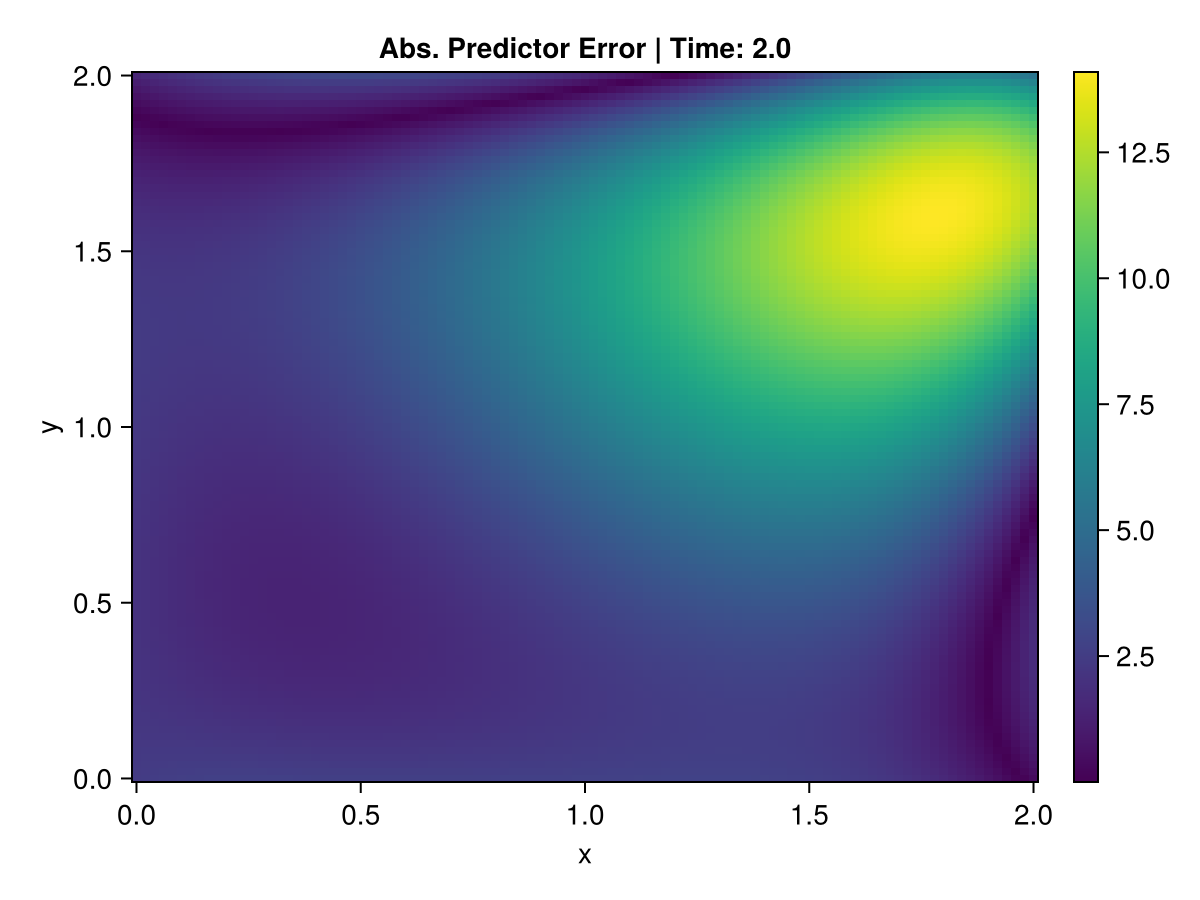

In [32]:
ts, xs, ys = 0.0f0:0.05f0:2.0f0, 0.0f0:0.02f0:2.0f0, 0.0f0:0.02f0:2.0f0
grid = stack([[elem...] for elem in vec(collect(Iterators.product(xs, ys, ts)))])

u_real = reshape(analytical_solution(grid), length(xs), length(ys), length(ts))

grid_normalized = (grid .- minimum(grid)) ./ (maximum(grid) .- minimum(grid))
u_pred = reshape(trained_u(grid_normalized), length(xs), length(ys), length(ts))
u_pred = u_pred .* (max_pde_val - min_pde_val) .+ min_pde_val

begin
    fig = Figure()
    ax = CairoMakie.Axis(fig[1, 1]; xlabel="x", ylabel="y")
    errs = [abs.(u_pred[:, :, i] .- u_real[:, :, i]) for i in 1:length(ts)]
    Colorbar(fig[1, 2]; limits=extrema(stack(errs)))

    CairoMakie.record(fig, "pinn_nested_ad.gif", 1:length(ts); framerate=10) do i
        ax.title = "Abs. Predictor Error | Time: $(ts[i])"
        err = errs[i]
        contour!(ax, xs, ys, err; levels=10, linewidth=2)
        heatmap!(ax, xs, ys, err)
        return fig
    end

    fig
end

![](pinn_nested_ad.gif)

# Accelerating Tensor Workloads with Reactant

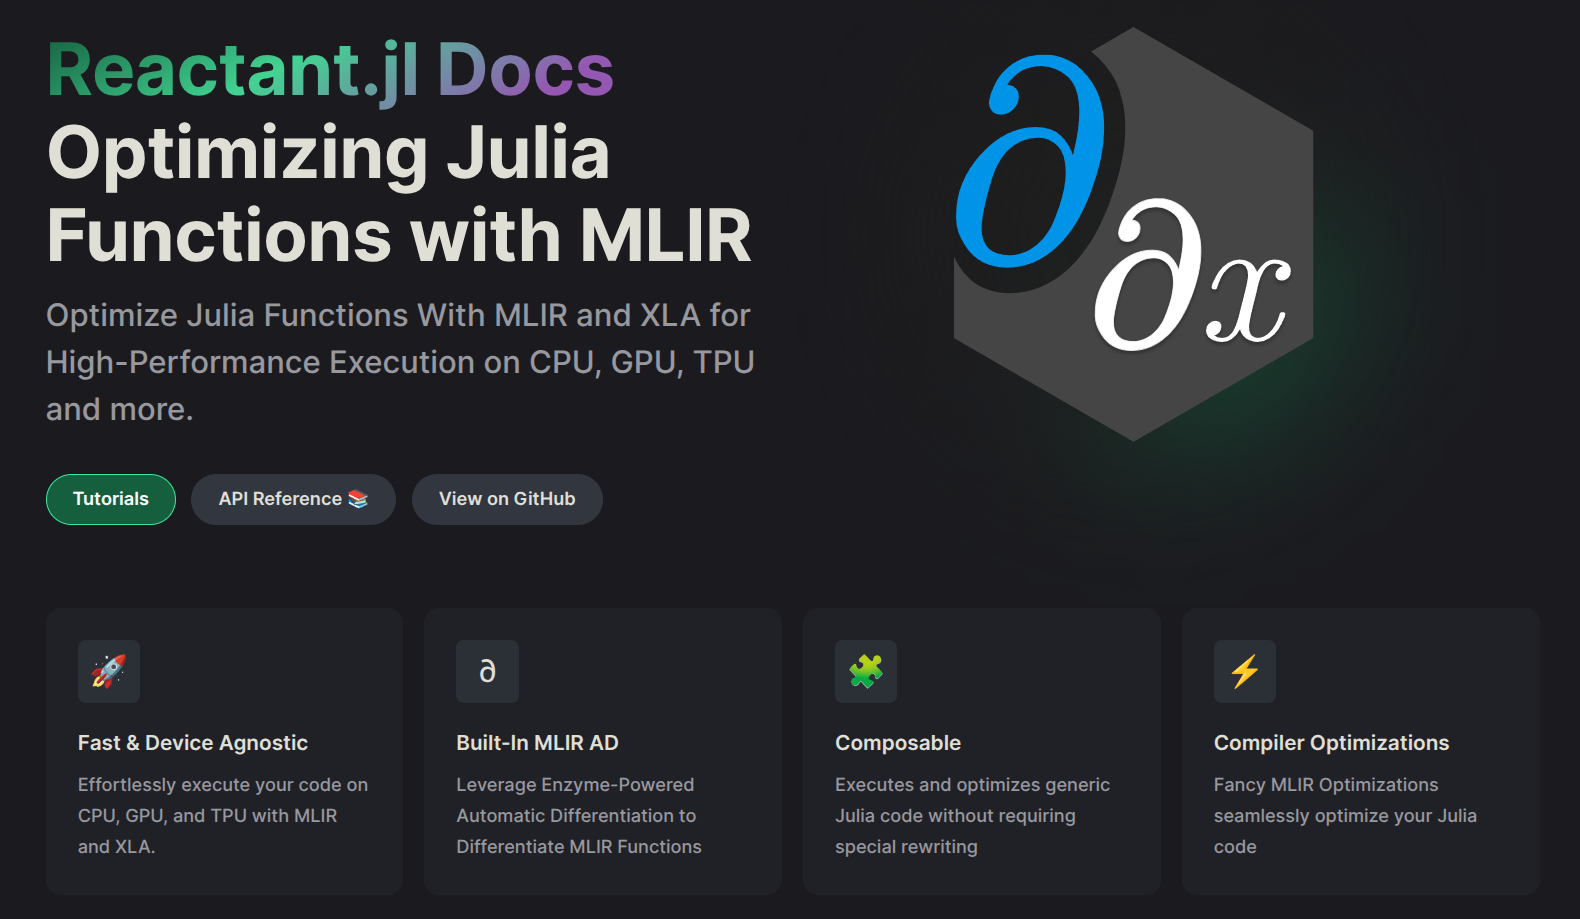

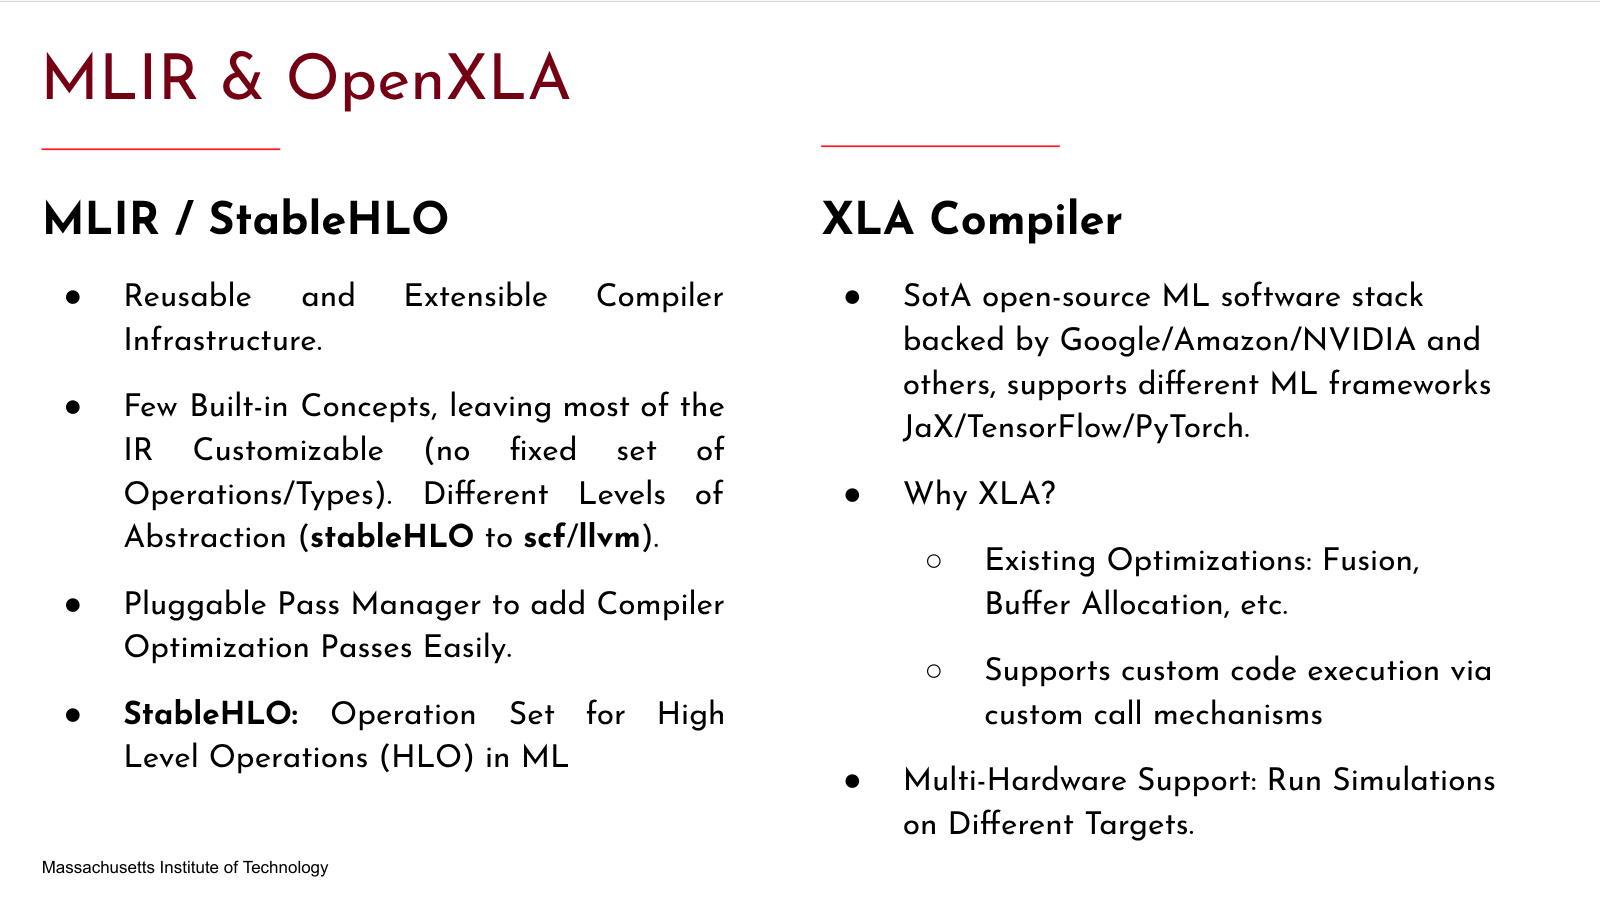

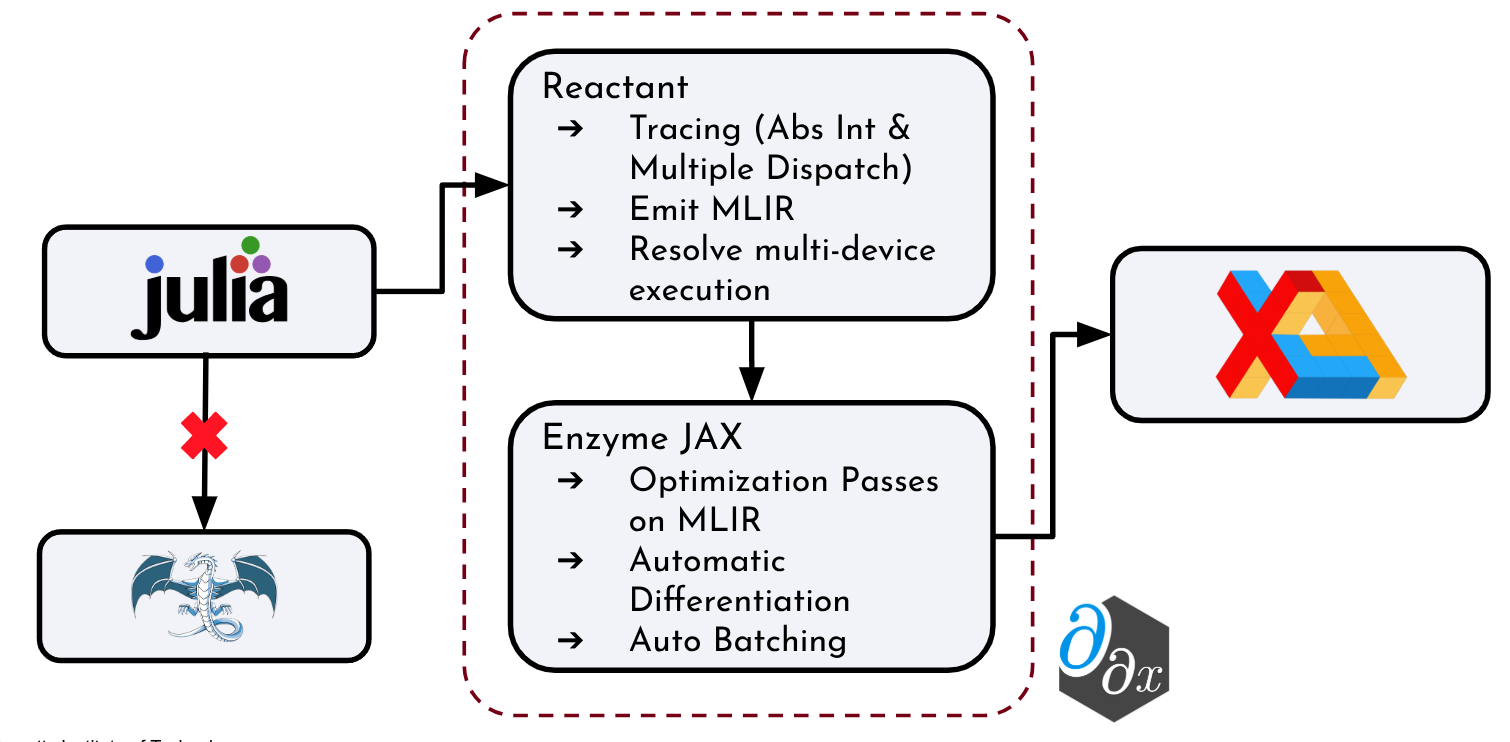

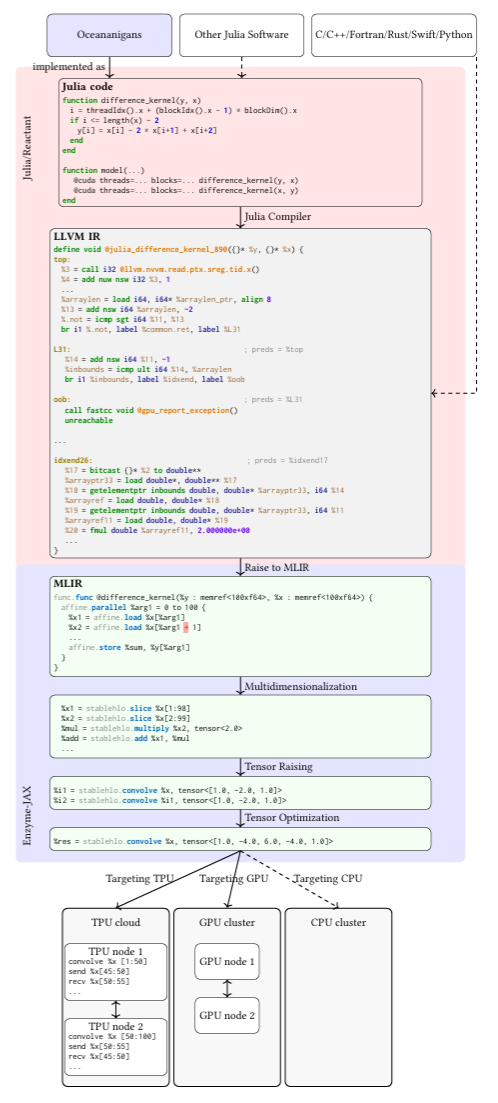

In [5]:
devices = Reactant.devices()

I0000 00:00:1745724825.007040  980116 pjrt_client.cc:529] PjRt-IFRT device count: total=1, addressable=1
I0000 00:00:1745724825.007062  980116 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=0)
2025-04-26 23:33:45.081667: I external/xla/xla/service/service.cc:152] XLA service 0x2d35ed70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-26 23:33:45.081691: I external/xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1745724825.083448  980116 se_gpu_pjrt_client.cc:999] Using BFC allocator.
I0000 00:00:1745724825.083514  980116 gpu_helpers.cc:136] XLA backend allocating 4547002368 bytes on device 0 for BFCAllocator.
I0000 00:00:1745724825.083541  980116 gpu_helpers.cc:177] XLA backend will use up to 1515667456 bytes on device 0 for CollectiveBFCAllocator.
I0000 00:00:1745724825.101877  980116 cuda_dnn.cc:527] Loaded cuDNN version 90400
I0000 00:00:

1-element Vector{Reactant.XLA.IFRT.Device}:
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002b2962b0, "CUDA:0 NVIDIA GeForce RTX 4050 Laptop GPU")

Similar to how Julia provides several macros to examine performance and visualize code, Reactant exposes:

1. `@code_hlo` -- your best friend to check the generated MLIR
2. `@code_xla` -- introspect the code after XLA optimizations (not recommended when getting started with Reactant, unless all options are exhausted)

## Automatic Compilation without Manual Rewriting

### Multiple Dispatch

In [8]:
# Step 1. Give ownership of the array to Reactant
x = rand(Float32, 4, 2) |> Reactant.to_rarray

AssertionError(

I0000 00:00:1745720992.457061  960287 pjrt_client.cc:529] PjRt-IFRT device count: total=8, addressable=8
I0000 00:00:1745720992.457092  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=0)
I0000 00:00:1745720992.457095  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=1)
I0000 00:00:1745720992.457096  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=2)
I0000 00:00:1745720992.457096  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=3)
I0000 00:00:1745720992.457097  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=4)
I0000 00:00:1745720992.457098  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=5)
I0000 00:00:1745720992.457098  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=6)
I0000 00:00:1745720992.457099  960287 pjrt_client.cc:533] Addressable PjRt-IFRT device: CpuDevice(id=7)
2025-04-26 22:29:52.485767: E external/xla/xla/stream_executor/

"No visible GPU devices.")


4×2 ConcreteIFRTArray{Float32,2}:
 0.271993  0.013809
 0.522813  0.0393298
 0.223076  0.943796
 0.400978  0.158397

In [10]:
# Step 2. Wrap the call with a `@jit`
@jit rfft(x)

3×2 ConcreteIFRTArray{ComplexF32,2}:
  2.57419+0.0im         0.263529+0.0im
 -0.88107-0.00276828im  0.978904-0.240902im
 0.331155+0.0im          -1.1886+0.0im

In [11]:
# Better Way: Compile the function ad cache it
rfft_compiled = @compile rfft(x)
rfft_compiled(x)

3×2 ConcreteIFRTArray{ComplexF32,2}:
  2.57419+0.0im         0.263529+0.0im
 -0.88107-0.00276828im  0.978904-0.240902im
 0.331155+0.0im          -1.1886+0.0im

What is happening under the hood?

In [14]:
Reactant.Compiler.DEBUG_PRINT_CODEGEN[] = true  # just for showing what happens

@compile rfft(x)

quote
    #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:3057 =#
    global_mesh = ()
    #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:3058 =#
    donated_buffers = Base.IdSet{XLA.IFRT.Array}()
    #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:3059 =#
    donated_args_mask = thunk.donated_args_mask
    #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:3060 =#
    carg_1 = getindex(args, 1)
    usbuf_1 = carg_1.data
    sbuf_1 = XLA.synced_buffer(usbuf_1)
    donate_argument!(donated_args_mask, carg_1, 1, donated_buffers, (:args, 1))
    #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:3061 =#
    begin
        #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:2709 =#
        #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:2709 =# GC.@preserve sbuf_1 begin
                #= /mnt/.julia/packages/Reactant/uDPOr/src/Compiler.jl:2710 =#
                linearized_results = XLA.execute_sharded(thunk.exec, thunk.device, (sbuf_1.buffer,), UInt

Reactant compiled function rfft (with tag ##rfft_reactant#280)

In [16]:
@code_hlo optimize=false rfft(x)

module @reactant_rfft attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<2x4xf32> {tf.aliasing_output = 1 : i32}) -> (tensor<2x3xcomplex<f32>>, tensor<2x4xf32>) {
    %0 = stablehlo.transpose %arg0, dims = [1, 0] : (tensor<2x4xf32>) -> tensor<4x2xf32>
    %1 = stablehlo.transpose %0, dims = [1, 0] : (tensor<4x2xf32>) -> tensor<2x4xf32>
    %2 = stablehlo.fft %1, type =  RFFT, length = [2, 4] : (tensor<2x4xf32>) -> tensor<2x3xcomplex<f32>>
    %3 = stablehlo.transpose %2, dims = [1, 0] : (tensor<2x3xcomplex<f32>>) -> tensor<3x2xcomplex<f32>>
    %4 = stablehlo.transpose %3, dims = [1, 0] : (tensor<3x2xcomplex<f32>>) -> tensor<2x3xcomplex<f32>>
    %5 = stablehlo.transpose %0, dims = [1, 0] : (tensor<4x2xf32>) -> tensor<2x4xf32>
    return %4, %5 : tensor<2x3xcomplex<f32>>, tensor<2x4xf32>
  }
}

In [17]:
@code_hlo optimize=true rfft(x)

module @reactant_rfft attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<2x4xf32>) -> tensor<2x3xcomplex<f32>> {
    %0 = stablehlo.fft %arg0, type =  RFFT, length = [2, 4] : (tensor<2x4xf32>) -> tensor<2x3xcomplex<f32>>
    return %0 : tensor<2x3xcomplex<f32>>
  }
}

### Abstract Interpretation

How do you overload `Random.default_rng()` (you can't)? All functions might not be dispatched on `Traced*` types

In [20]:
@code_hlo randn(Random.default_rng(), 2, 3)  # <--- automatically translated to generate SHLO for sampling

module @reactant_randn attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main() -> tensor<3x2xf64> {
    %cst = stablehlo.constant dense<1.4142135623730951> : tensor<3x2xf64>
    %cst_0 = stablehlo.constant dense<2.000000e+00> : tensor<3x2xf64>
    %cst_1 = stablehlo.constant dense<1.000000e+00> : tensor<3x2xf64>
    %c = stablehlo.constant dense<4607182418800017408> : tensor<2x3xui64>
    %c_2 = stablehlo.constant dense<12> : tensor<2x3xui64>
    %c_3 = stablehlo.constant dense<[5942795161929910459, 6728614163286556920]> : tensor<2xui64>
    %output_state, %output = stablehlo.rng_bit_generator %c_3, algorithm =  DEFAULT : (tensor<2xui64>) -> (tensor<2xui64>, tensor<2x3xui64>)
    %0 = stablehlo.shift_right_logical %output, %c_2 : tensor<2x3xui64>
    %1 = stablehlo.or %0, %c : tensor<2x3xui64>
    %2 = stablehlo.bitcast_convert %1 : (tensor<2x3xui64>) -> tensor<2x3xf64>
    %3 = stablehlo.transpose %2, dims = [1, 0] : (tensor<2x3xf64>) -> tensor<3x

### Compiler Optimizations

In [21]:
function relu(x::T) where {T}
    @trace if x < 0
        x = T(0)
    end
    return x
end

relu (generic function with 1 method)

In [24]:
@code_hlo optimize=false relu(ConcreteRNumber(3.0))

module @reactant_relu attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<f64> {tf.aliasing_output = 1 : i32}) -> (tensor<f64>, tensor<f64>) {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f64>
    %0 = stablehlo.compare  LT, %arg0, %cst : (tensor<f64>, tensor<f64>) -> tensor<i1>
    %1:2 = "stablehlo.if"(%0) ({
      %cst_0 = stablehlo.constant dense<0.000000e+00> : tensor<f64>
      stablehlo.return %arg0, %cst_0 : tensor<f64>, tensor<f64>
    }, {
      stablehlo.return %arg0, %arg0 : tensor<f64>, tensor<f64>
    }) : (tensor<i1>) -> (tensor<f64>, tensor<f64>)
    return %1#1, %1#0 : tensor<f64>, tensor<f64>
  }
}

In [25]:
@code_xla optimize=false relu(ConcreteRNumber(3.0))  # <---- terrible for performance

HloModule reactant_relu, is_scheduled=true, input_output_alias={ {1}: (0, {}, may-alias) }, entry_computation_layout={(f64[])->(f64[], f64[])}

%region_0.4 (Arg_.0: (f64[])) -> (f64[], f64[]) {
  %constant.6 = f64[] constant(0)
  %Arg_.0 = (f64[]) parameter(0)
  %copy.4 = f64[] copy(%constant.6)
  %get-tuple-element.2 = f64[] get-tuple-element(%Arg_.0), index=0
  ROOT %tuple.2 = (f64[], f64[]) tuple(%get-tuple-element.2, %copy.4)
}

%region_1.8 (Arg_.1: (f64[])) -> (f64[], f64[]) {
  %Arg_.1 = (f64[]) parameter(0)
  %get-tuple-element.5 = f64[] get-tuple-element(%Arg_.1), index=0
  %copy.1 = f64[] copy(%get-tuple-element.5)
  ROOT %tuple.3 = (f64[], f64[]) tuple(%get-tuple-element.5, %copy.1)
}

ENTRY %main.15 (Arg_0.1: f64[]) -> (f64[], f64[]) {
  %Arg_0.1 = f64[] parameter(0), metadata={op_name="arg1 (path=(:args, 1))"}
  %constant.2 = f64[] constant(0)
  %tuple = (f64[]) tuple(%Arg_0.1)
  %compare.3 = pred[] compare(%Arg_0.1, %constant.2), direction=LT, metadata={op_name="compare" s

In [27]:
@code_hlo relu(ConcreteRNumber(3.0))  # <--- no branching!

module @reactant_relu attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<f64>) -> tensor<f64> {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f64>
    %0 = stablehlo.maximum %cst, %arg0 : tensor<f64>
    return %0 : tensor<f64>
  }
}

In [28]:
@code_xla relu(ConcreteRNumber(3.0))  # <--- much nicer codegen!

HloModule reactant_relu, is_scheduled=true, entry_computation_layout={(f64[])->f64[]}

ENTRY %main.4 (Arg_0.1: f64[]) -> f64[] {
  %Arg_0.1 = f64[] parameter(0), metadata={op_name="arg1 (path=(:args, 1))"}
  %constant.2 = f64[] constant(0)
  ROOT %maximum.3 = f64[] maximum(%Arg_0.1, %constant.2)
}



In [10]:
good_permutedims(x) = permutedims(x, [1, 3, 2])

function bad_permutedims(x)  # Trust me not a contrived case, someone opened an issue a week ago
    xs = [reshape(x[:, :, i], size(x, 1), 1, size(x, 2)) for i in axes(x, 3)]
    return cat(xs...; dims=2)
end

bad_permutedims (generic function with 1 method)

In [11]:
x_ra = Reactant.to_rarray(rand(4, 5, 3));

In [12]:
@code_hlo optimize=false good_permutedims(x_ra)

1 = 1
1 = 1


module @reactant_good_pe... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf64> {tf.aliasing_output = 1 : i32}) -> (tensor<5x3x4xf64>, tensor<3x5x4xf64>) {
    %0 = stablehlo.transpose %arg0, dims = [2, 1, 0] : (tensor<3x5x4xf64>) -> tensor<4x5x3xf64>
    %1 = stablehlo.transpose %0, dims = [0, 2, 1] : (tensor<4x5x3xf64>) -> tensor<4x3x5xf64>
    %2 = stablehlo.transpose %1, dims = [2, 1, 0] : (tensor<4x3x5xf64>) -> tensor<5x3x4xf64>
    %3 = stablehlo.transpose %0, dims = [2, 1, 0] : (tensor<4x5x3xf64>) -> tensor<3x5x4xf64>
    return %2, %3 : tensor<5x3x4xf64>, tensor<3x5x4xf64>
  }
}

In [13]:
@code_hlo optimize=true good_permutedims(x_ra)

1 = 1
1 = 1
1 = 1


module @reactant_good_pe... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf64>) -> tensor<5x3x4xf64> {
    %0 = stablehlo.transpose %arg0, dims = [1, 0, 2] : (tensor<3x5x4xf64>) -> tensor<5x3x4xf64>
    return %0 : tensor<5x3x4xf64>
  }
}

In [14]:
@code_xla optimize=true good_permutedims(x_ra)

1 = 1
1 = 1
1 = 1


HloModule reactant_good_pe..., is_scheduled=true, entry_computation_layout={(f64[3,5,4]{2,1,0})->f64[5,3,4]{2,1,0}}

%fused_computation (param_0.1: f64[3,5,4]) -> f64[5,3,4] {
  %param_0.1 = f64[3,5,4]{2,1,0} parameter(0)
  %transpose.0 = f64[5,3,4]{2,0,1} transpose(%param_0.1), dimensions={1,0,2}
  ROOT %copy.1 = f64[5,3,4]{2,1,0} copy(%transpose.0)
}

ENTRY %main.3 (Arg_0.1: f64[3,5,4]) -> f64[5,3,4] {
  %Arg_0.1 = f64[3,5,4]{2,1,0} parameter(0), metadata={op_name="arg1 (path=(:args, 1))"}
  ROOT %transpose_copy_fusion = f64[5,3,4]{2,1,0} fusion(%Arg_0.1), kind=kLoop, calls=%fused_computation
}



In [15]:
@code_hlo optimize=false bad_permutedims(x_ra)

1 = 1
1 = 1


module @reactant_bad_per... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf64> {tf.aliasing_output = 1 : i32}) -> (tensor<5x3x4xf64>, tensor<3x5x4xf64>) {
    %0 = stablehlo.transpose %arg0, dims = [2, 1, 0] : (tensor<3x5x4xf64>) -> tensor<4x5x3xf64>
    %c = stablehlo.constant dense<0> : tensor<i32>
    %c_0 = stablehlo.constant dense<0> : tensor<i32>
    %c_1 = stablehlo.constant dense<0> : tensor<i32>
    %1 = stablehlo.dynamic_slice %0, %c, %c_0, %c_1, sizes = [4, 5, 1] : (tensor<4x5x3xf64>, tensor<i32>, tensor<i32>, tensor<i32>) -> tensor<4x5x1xf64>
    %2 = stablehlo.transpose %1, dims = [2, 1, 0] : (tensor<4x5x1xf64>) -> tensor<1x5x4xf64>
    %3 = stablehlo.reshape %2 : (tensor<1x5x4xf64>) -> tensor<5x4xf64>
    %4 = stablehlo.transpose %3, dims = [1, 0] : (tensor<5x4xf64>) -> tensor<4x5xf64>
    %c_2 = stablehlo.constant dense<0> : tensor<i32>
    %c_3 = stablehlo.constant dense<0> : tensor<i32>
    %c_4 = stable

In [16]:
@code_xla optimize=false bad_permutedims(x_ra)

1 = 1
1 = 1


HloModule reactant_bad_per..., is_scheduled=true, input_output_alias={ {1}: (0, {}, may-alias) }, entry_computation_layout={(f64[3,5,4]{2,1,0})->(f64[5,3,4]{2,1,0}, f64[3,5,4]{2,1,0})}

%fused_computation (param_0.4: f64[3,5,4]) -> f64[5,3,4] {
  %param_0.4 = f64[3,5,4]{2,1,0} parameter(0)
  %transpose.8 = f64[4,5,3]{0,1,2} transpose(%param_0.4), dimensions={2,1,0}
  %copy.18 = f64[4,5,3]{2,1,0} copy(%transpose.8)
  %slice.2 = f64[4,5,1]{2,1,0} slice(%copy.18), slice={[0:4], [0:5], [0:1]}, metadata={op_name="dynamic_slice" source_file="/mnt/.julia/dev/Reactant/src/Ops.jl" source_line=2737}
  %transpose.6 = f64[1,5,4]{0,1,2} transpose(%slice.2), dimensions={2,1,0}, metadata={op_name="transpose" source_file="/mnt/.julia/dev/Reactant/src/Ops.jl" source_line=496}
  %copy.17 = f64[1,5,4]{2,1,0} copy(%transpose.6), metadata={op_name="transpose" source_file="/mnt/.julia/dev/Reactant/src/Ops.jl" source_line=496}
  %bitcast.5 = f64[5,1,4]{2,1,0} bitcast(%copy.17), metadata={op_name="transpose" 

In [17]:
@code_hlo optimize=true bad_permutedims(x_ra)

1 = 1
1 = 1
1 = 1


module @reactant_bad_per... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf64>) -> tensor<5x3x4xf64> {
    %0 = stablehlo.transpose %arg0, dims = [1, 0, 2] : (tensor<3x5x4xf64>) -> tensor<5x3x4xf64>
    return %0 : tensor<5x3x4xf64>
  }
}

## Core Compiler (EnzymeJAX) is Language-Agnostic

Support for JAX and C++ are already implemented. In-principl, even works with Pytorch XLA and Fortran (Flang) if they emit stablehlo.

```python
from enzyme_ad.jax import cpp_call

# Forward-mode C++ AD example

@jax.jit
def something(inp):
    y = cpp_call(inp, out_shapes=[jax.core.ShapedArray([2, 3], jnp.float32)], source="""
        template<std::size_t N, std::size_t M>
        void myfn(enzyme::tensor<float, N, M>& out0, const enzyme::tensor<float, N, M>& in0) {
        out0 = 56.0f + in0(0, 0);
        }
        """, fn="myfn")
    return y

ones = jnp.ones((2, 3), jnp.float32)
primals, tangents = jax.jvp(something, (ones,), (ones,) )

# Reverse-mode C++ AD example

primals, f_vjp = jax.vjp(something, ones)
(grads,) = f_vjp((x,))
```

## Automatic Differentiation of MLIR

In [18]:
function mseloss(model, x, ps, st, y)
    y_pred, _ = model(x, ps, st)
    return sum(abs2, y_pred .- y)
end

mseloss (generic function with 1 method)

In [29]:
xyt_ra = Reactant.to_rarray(xyt)
ps_ra = Reactant.to_rarray(ps)
st_ra = Reactant.to_rarray(st)
y_ra = Reactant.to_rarray(rand(Float32, 3, 32));

In [36]:
@code_hlo optimize="enzyme-batch,inline,enzyme-hlo-opt" Enzyme.gradient(Enzyme.Reverse, mseloss, Const(pinn), xyt_ra, ps_ra, Const(st_ra), Const(y_ra))

module @reactant_gradient attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func private @"Const{typeof(mseloss)}(Main.mseloss)_autodiff"(%arg0: tensor<32x3xf32>, %arg1: tensor<3x32xf32>, %arg2: tensor<32xf32>, %arg3: tensor<32x32xf32>, %arg4: tensor<32xf32>, %arg5: tensor<32x32xf32>, %arg6: tensor<32xf32>, %arg7: tensor<32x3xf32>, %arg8: tensor<3xf32>, %arg9: tensor<32x3xf32>) -> (tensor<f32>, tensor<32x3xf32>, tensor<3x32xf32>, tensor<32xf32>, tensor<32x32xf32>, tensor<32xf32>, tensor<32x32xf32>, tensor<32xf32>, tensor<32x3xf32>, tensor<3xf32>, tensor<32x3xf32>) {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = stablehlo.transpose %arg9, dims = [1, 0] : (tensor<32x3xf32>) -> tensor<3x32xf32>
    %1 = stablehlo.dot_general %arg1, %arg0, contracting_dims = [0] x [1], precision = [DEFAULT, DEFAULT] : (tensor<3x32xf32>, tensor<32x3xf32>) -> tensor<32x32xf32>
    %2 = stablehlo.broadcast_in_dim %arg2, dims = [0] : (tensor<32xf32>) ->

In [34]:
@code_hlo Enzyme.gradient(Enzyme.Reverse, mseloss, Const(pinn), xyt_ra, ps_ra, Const(st_ra), Const(y_ra))

module @reactant_gradient attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<32x3xf32>, %arg1: tensor<3x32xf32>, %arg2: tensor<32xf32>, %arg3: tensor<32x32xf32>, %arg4: tensor<32xf32>, %arg5: tensor<32x32xf32>, %arg6: tensor<32xf32>, %arg7: tensor<32x3xf32>, %arg8: tensor<3xf32>, %arg9: tensor<32x3xf32>) -> (tensor<32x3xf32>, tensor<3x32xf32>, tensor<32xf32>, tensor<32x32xf32>, tensor<32xf32>, tensor<32x32xf32>, tensor<32xf32>, tensor<32x3xf32>, tensor<3xf32>) {
    %cst = stablehlo.constant dense<2.000000e+00> : tensor<3x32xf32>
    %cst_0 = stablehlo.constant dense<1.000000e+00> : tensor<32x32xf32>
    %cst_1 = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = stablehlo.transpose %arg9, dims = [1, 0] : (tensor<32x3xf32>) -> tensor<3x32xf32>
    %1 = stablehlo.dot_general %arg1, %arg0, contracting_dims = [0] x [1], precision = [DEFAULT, DEFAULT] : (tensor<3x32xf32>, tensor<32x3xf32>) -> tensor<32x32xf32>
    %2 = stabl

In [39]:
@jit Enzyme.gradient(Enzyme.Reverse, mseloss, Const(pinn), xyt_ra, ps_ra, Const(st_ra), Const(y_ra))

(nothing, ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[-4.5687666 1.0145276 … -1.5920478 0.80549794; 2.4053802 0.46929315 … -1.6909521 0.10023761; 1.2398167 -1.3815726 … 0.4573164 -1.6408857]), (model = (layer_1 = (weight = ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[-2.2222447 -1.5071079 -2.0193424; 0.6475653 0.11940551 1.8417606; … ; -2.8357217 -2.986352 -3.3327656; 0.049344093 0.09497677 0.95826334]), bias = ConcreteIFRTArray{Float32, 1, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[-5.1136613, 2.2611356, 2.006604, -0.73603356, -14.397863, 17.651249, -11.823265, -4.961418, -0.1913734, 5.6734095  …  -3.198045, -7.914952, 8.825904, -11.167649, 18.021524, -4.5598063, 9.301705, 4.810555, -7.625853, 1.3645651])), layer_2 = (weight = ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoS

## Automatic Batching (similar to `jax.vmap`) _(Experimental)_

And again it happens at the MLIR level! (and extends beyond just Jax)

In [23]:
x = rand(Float32, 4, 5, 3)
x_ra = x |> Reactant.to_rarray

4×5×3 ConcreteIFRTArray{Float32,3}:
[:, :, 1] =
 0.818985   0.715194  0.560968  0.533785  0.677466
 0.113118   0.6639    0.122065  0.706897  0.800667
 0.448766   0.935488  0.446524  0.809967  0.800979
 0.0472407  0.433278  0.39839   0.928774  0.784505

[:, :, 2] =
 0.500751  0.338749  0.569542  0.686253   0.683523
 0.542733  0.324326  0.666765  0.895051   0.848176
 0.25338   0.715839  0.559177  0.0961521  0.672609
 0.101661  0.384532  0.737395  0.15132    0.478895

[:, :, 3] =
 0.496255  0.83683    0.0858137  0.690473  0.90306
 0.617952  0.993077   0.801144   0.73769   0.0627074
 0.998097  0.697692   0.6016     0.912193  0.276104
 0.419383  0.0519773  0.137014   0.663082  0.927619

The most common case for batching is just broadcasting

In [27]:
@code_hlo optimize="enzyme-hlo-opt" sin.(x_ra)

module @reactant_Base.Br... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func private @sin_broadcast_scalar(%arg0: tensor<f32>) -> (tensor<f32>, tensor<f32>) {
    %0 = stablehlo.sine %arg0 : tensor<f32>
    return %0, %arg0 : tensor<f32>, tensor<f32>
  }
  func.func @main(%arg0: tensor<3x5x4xf32>) -> tensor<3x5x4xf32> {
    %0 = stablehlo.transpose %arg0, dims = [2, 1, 0] : (tensor<3x5x4xf32>) -> tensor<4x5x3xf32>
    %1:2 = enzyme.batch @sin_broadcast_scalar(%0) {batch_shape = array<i64: 4, 5, 3>} : (tensor<4x5x3xf32>) -> (tensor<4x5x3xf32>, tensor<4x5x3xf32>)
    %2 = stablehlo.transpose %1#0, dims = [2, 1, 0] : (tensor<4x5x3xf32>) -> tensor<3x5x4xf32>
    return %2 : tensor<3x5x4xf32>
  }
}

In [28]:
@code_hlo optimize="enzyme-hlo-opt,enzyme-batch" sin.(x_ra)

module @reactant_Base.Br... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func private @sin_broadcast_scalar(%arg0: tensor<f32>) -> (tensor<f32>, tensor<f32>) {
    %0 = stablehlo.sine %arg0 : tensor<f32>
    return %0, %arg0 : tensor<f32>, tensor<f32>
  }
  func.func private @batched_sin_broadcast_scalar(%arg0: tensor<4x5x3xf32>) -> (tensor<4x5x3xf32>, tensor<4x5x3xf32>) {
    %0 = stablehlo.sine %arg0 : tensor<4x5x3xf32>
    return %0, %arg0 : tensor<4x5x3xf32>, tensor<4x5x3xf32>
  }
  func.func @main(%arg0: tensor<3x5x4xf32>) -> tensor<3x5x4xf32> {
    %0 = stablehlo.transpose %arg0, dims = [2, 1, 0] : (tensor<3x5x4xf32>) -> tensor<4x5x3xf32>
    %1:2 = call @batched_sin_broadcast_scalar(%0) : (tensor<4x5x3xf32>) -> (tensor<4x5x3xf32>, tensor<4x5x3xf32>)
    %2 = stablehlo.transpose %1#0, dims = [2, 1, 0] : (tensor<4x5x3xf32>) -> tensor<3x5x4xf32>
    return %2 : tensor<3x5x4xf32>
  }
}

In [29]:
@code_hlo optimize=true sin.(x_ra)

module @reactant_Base.Br... attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf32>) -> tensor<3x5x4xf32> {
    %0 = stablehlo.sine %arg0 : tensor<3x5x4xf32>
    return %0 : tensor<3x5x4xf32>
  }
}

Currently the only other way of interacting with batching is via `mapslices`

In [31]:
mapslices(x -> sum(x; dims=1), x; dims=(1, 3))

1×5×3 Array{Float32, 3}:
[:, :, 1] =
 1.42811  2.74786  1.52795  2.97942  3.06362

[:, :, 2] =
 1.39853  1.76345  2.53288  1.82878  2.6832

[:, :, 3] =
 2.53169  2.57958  1.62557  3.00344  2.16949

In [33]:
@code_hlo optimize="enzyme-hlo-opt" mapslices(x -> sum(x; dims=1), x_ra; dims=(1, 3))

module @reactant_mapslices attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func private @identity_broadcast_scalar(%arg0: tensor<f32>) -> tensor<f32> {
    return %arg0 : tensor<f32>
  }
  func.func private @"unbatched_#10"(%arg0: tensor<4x3xf32>) -> tensor<1x3xf32> {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = enzyme.batch @identity_broadcast_scalar(%arg0) {batch_shape = array<i64: 4, 3>} : (tensor<4x3xf32>) -> tensor<4x3xf32>
    %1 = stablehlo.reduce(%0 init: %cst) applies stablehlo.add across dimensions = [0] : (tensor<4x3xf32>, tensor<f32>) -> tensor<3xf32>
    %2 = stablehlo.reshape %1 : (tensor<3xf32>) -> tensor<1x3xf32>
    return %2 : tensor<1x3xf32>
  }
  func.func @main(%arg0: tensor<3x5x4xf32>) -> tensor<3x5x1xf32> {
    %0 = stablehlo.transpose %arg0, dims = [1, 2, 0] : (tensor<3x5x4xf32>) -> tensor<5x4x3xf32>
    %1 = enzyme.batch @"unbatched_#10"(%0) {batch_shape = array<i64: 5>} : (tensor<5x4x3xf32>) -> tenso

In [34]:
@code_hlo optimize="enzyme-hlo-opt,enzyme-batch" mapslices(x -> sum(x; dims=1), x_ra; dims=(1, 3))

module @reactant_mapslices attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func private @identity_broadcast_scalar(%arg0: tensor<f32>) -> tensor<f32> {
    return %arg0 : tensor<f32>
  }
  func.func private @"unbatched_#12"(%arg0: tensor<4x3xf32>) -> tensor<1x3xf32> {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = call @batched_identity_broadcast_scalar(%arg0) : (tensor<4x3xf32>) -> tensor<4x3xf32>
    %1 = stablehlo.reduce(%0 init: %cst) applies stablehlo.add across dimensions = [0] : (tensor<4x3xf32>, tensor<f32>) -> tensor<3xf32>
    %2 = stablehlo.reshape %1 : (tensor<3xf32>) -> tensor<1x3xf32>
    return %2 : tensor<1x3xf32>
  }
  func.func private @batched_identity_broadcast_scalar(%arg0: tensor<4x3xf32>) -> tensor<4x3xf32> {
    return %arg0 : tensor<4x3xf32>
  }
  func.func private @"batched_unbatched_#12"(%arg0: tensor<5x4x3xf32>) -> tensor<5x1x3xf32> {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<5xf32>


In [35]:
@code_hlo optimize=true mapslices(x -> sum(x; dims=1), x_ra; dims=(1, 3))

module @reactant_mapslices attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  func.func @main(%arg0: tensor<3x5x4xf32>) -> tensor<3x5x1xf32> {
    %cst = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = stablehlo.reduce(%arg0 init: %cst) applies stablehlo.add across dimensions = [2] : (tensor<3x5x4xf32>, tensor<f32>) -> tensor<3x5xf32>
    %1 = stablehlo.reshape %0 : (tensor<3x5xf32>) -> tensor<3x5x1xf32>
    return %1 : tensor<3x5x1xf32>
  }
}

## Automatically TPU/CPU-ification of CUDA kernels _(Experimental)_

In [32]:
function mul_kernel!(x, y)
    i = threadIdx().x
    x[i] *= y[i]
    return nothing
end

function cuda_mul!(x, y)
    @cuda blocks = 1 threads = length(x) mul_kernel!(x, y)
    return nothing
end

cuda_mul! (generic function with 1 method)

In [29]:
@code_hlo optimize=:before_kernel cuda_mul!(A, B)

#tbaa_root = #llvm.tbaa_root<id = "custom_tbaa">
#tbaa_type_desc = #llvm.tbaa_type_desc<id = "custom_tbaa_addrspace(1)", members = {<#tbaa_root, 0>}>
#tbaa_tag = #llvm.tbaa_tag<base_type = #tbaa_type_desc, access_type = #tbaa_type_desc, offset = 0>
module @"reactant_cuda_mul!" attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  llvm.module_flags [#llvm.mlir.module_flag<warning, "Dwarf Version", 2>, #llvm.mlir.module_flag<warning, "Debug Info Version", 3>]
  llvm.mlir.global private unnamed_addr constant @mlir.llvm.nameless_global_0("ERROR: Out of dynamic GPU memory (trying to allocate %d bytes)\0A\00") {addr_space = 0 : i32, alignment = 1 : i64, dso_local, sym_visibility = "private"}
  llvm.mlir.global private unnamed_addr constant @exception16("exception\00") {addr_space = 0 : i32, alignment = 1 : i64, dso_local, sym_visibility = "private"}
  llvm.func local_unnamed_addr @jl_bool_type() -> !llvm.ptr attributes {sym_visibility = "private"}
  llvm.func local_unna

In [25]:
@code_hlo cuda_mul!(A, B)

module @"reactant_cuda_mul!" attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  llvm.module_flags [#llvm.mlir.module_flag<warning, "Dwarf Version", 2>, #llvm.mlir.module_flag<warning, "Debug Info Version", 3>]
  func.func @main(%arg0: tensor<64xi64> {tf.aliasing_output = 0 : i32}, %arg1: tensor<64xi64>) -> tensor<64xi64> {
    %0 = stablehlo.custom_call @enzymexla_compile_cpu(%arg0, %arg1) {api_version = 3 : i32, backend_config = "\00\C0\0E~\AFz\00\00\00\00\00\00\00\00\00\00", output_operand_aliases = [#stablehlo.output_operand_alias<output_tuple_indices = [], operand_index = 0, operand_tuple_indices = []>]} : (tensor<64xi64>, tensor<64xi64>) -> tensor<64xi64>
    return %0 : tensor<64xi64>
  }
}

In [26]:
@code_hlo raise=true cuda_mul!(A, B)

module @"reactant_cuda_mul!" attributes {mhlo.num_partitions = 1 : i64, mhlo.num_replicas = 1 : i64} {
  llvm.module_flags [#llvm.mlir.module_flag<warning, "Dwarf Version", 2>, #llvm.mlir.module_flag<warning, "Debug Info Version", 3>]
  func.func @main(%arg0: tensor<64xi64> {tf.aliasing_output = 0 : i32}, %arg1: tensor<64xi64>) -> tensor<64xi64> {
    %0 = stablehlo.multiply %arg1, %arg0 : tensor<64xi64>
    return %0 : tensor<64xi64>
  }
}

In [34]:
begin
    oA = collect(1:1:64)
    A = Reactant.to_rarray(oA)
    B = Reactant.to_rarray(100 .* oA)
    @jit cuda_mul!(A, B)  # For anyone running on TPUs this should error
    A'
end

1×64 adjoint(::ConcreteIFRTArray{Int64,1}) with eltype Int64:
 100  400  900  1600  2500  3600  4900  …  372100  384400  396900  409600

In [35]:
begin
    oA = collect(1:1:64)
    A = Reactant.to_rarray(oA)
    B = Reactant.to_rarray(100 .* oA)
    @jit raise=true cuda_mul!(A, B)
    A'
end

1×64 adjoint(::ConcreteIFRTArray{Int64,1}) with eltype Int64:
 100  400  900  1600  2500  3600  4900  …  372100  384400  396900  409600

## Profiling using Perfetto

https://enzymead.github.io/Reactant.jl/stable/tutorials/profiling

In [16]:
ps_ra, st_ra = (ps, st) |> Reactant.to_rarray
xyt_ra = xyt |> Reactant.to_rarray

3×32 ConcreteIFRTArray{Float32,2}:
 0.981283   0.760614  0.94994   0.560433  …  0.243181  0.27843   0.808637
 0.48399    0.445965  0.62407   0.920198     0.515657  0.102529  0.965773
 0.0333194  0.132831  0.029117  0.694125     0.842758  0.597014  0.976512

In [18]:
compiled_pinn = @compile sync=true pinn(xyt_ra, ps_ra, st_ra)  # force a sync to ensure correct profiling

Reactant compiled function PhysicsInformedNN{Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}}(Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(3 => 32, tanh), layer_2 = Dense(32 => 32, tanh), layer_3 = Dense(32 => 32, tanh), layer_4 = Dense(32 => 3)), nothing)) (with tag ##PhysicsInformedNN{Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), In

In [19]:
Reactant.with_profiler("traces/") do
    compiled_pinn(xyt_ra, ps_ra, st_ra)
end

2025-04-26 20:00:17.202096: I external/tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-26 20:00:17.202110: I external/tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-04-26 20:00:17.386632: I external/tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-04-26 20:00:17.389450: I external/xla/xla/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: traces/plugins/profile/2025_04_26_20_00_17/avikomen.xplane.pb
2025-04-26 20:00:17.389810: I external/xla/xla/tsl/profiler/rpc/client/save_profile.cc:120] Creating directory: traces/plugins/profile/2025_04_26_20_00_17

2025-04-26 20:00:17.390126: I external/xla/xla/tsl/profiler/rpc/client/save_profile.cc:126] Dumped gzipped tool data for trace.json.gz to traces/plugins/profile/2025_04_26_20_00_17/avikomen.trace.json.gz
2025-04-26 20:00:17.390141: I external/tsl/tsl/profiler/lib/profiler_session.cc:136] Profiler session tear d

(ConcreteIFRTArray{Float32, 2, Reactant.Sharding.ShardInfo{Reactant.Sharding.NoSharding, Nothing}, Nothing}(Float32[1.0249436 1.1035991 … 1.2252343 0.9926837; 0.433671 0.27453902 … 0.23841803 0.4638543; -0.029659003 -0.037556827 … 0.3380532 -0.3741915]), (model = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()),))

Now open https://ui.perfetto.dev/ in your browser and load the trace file.

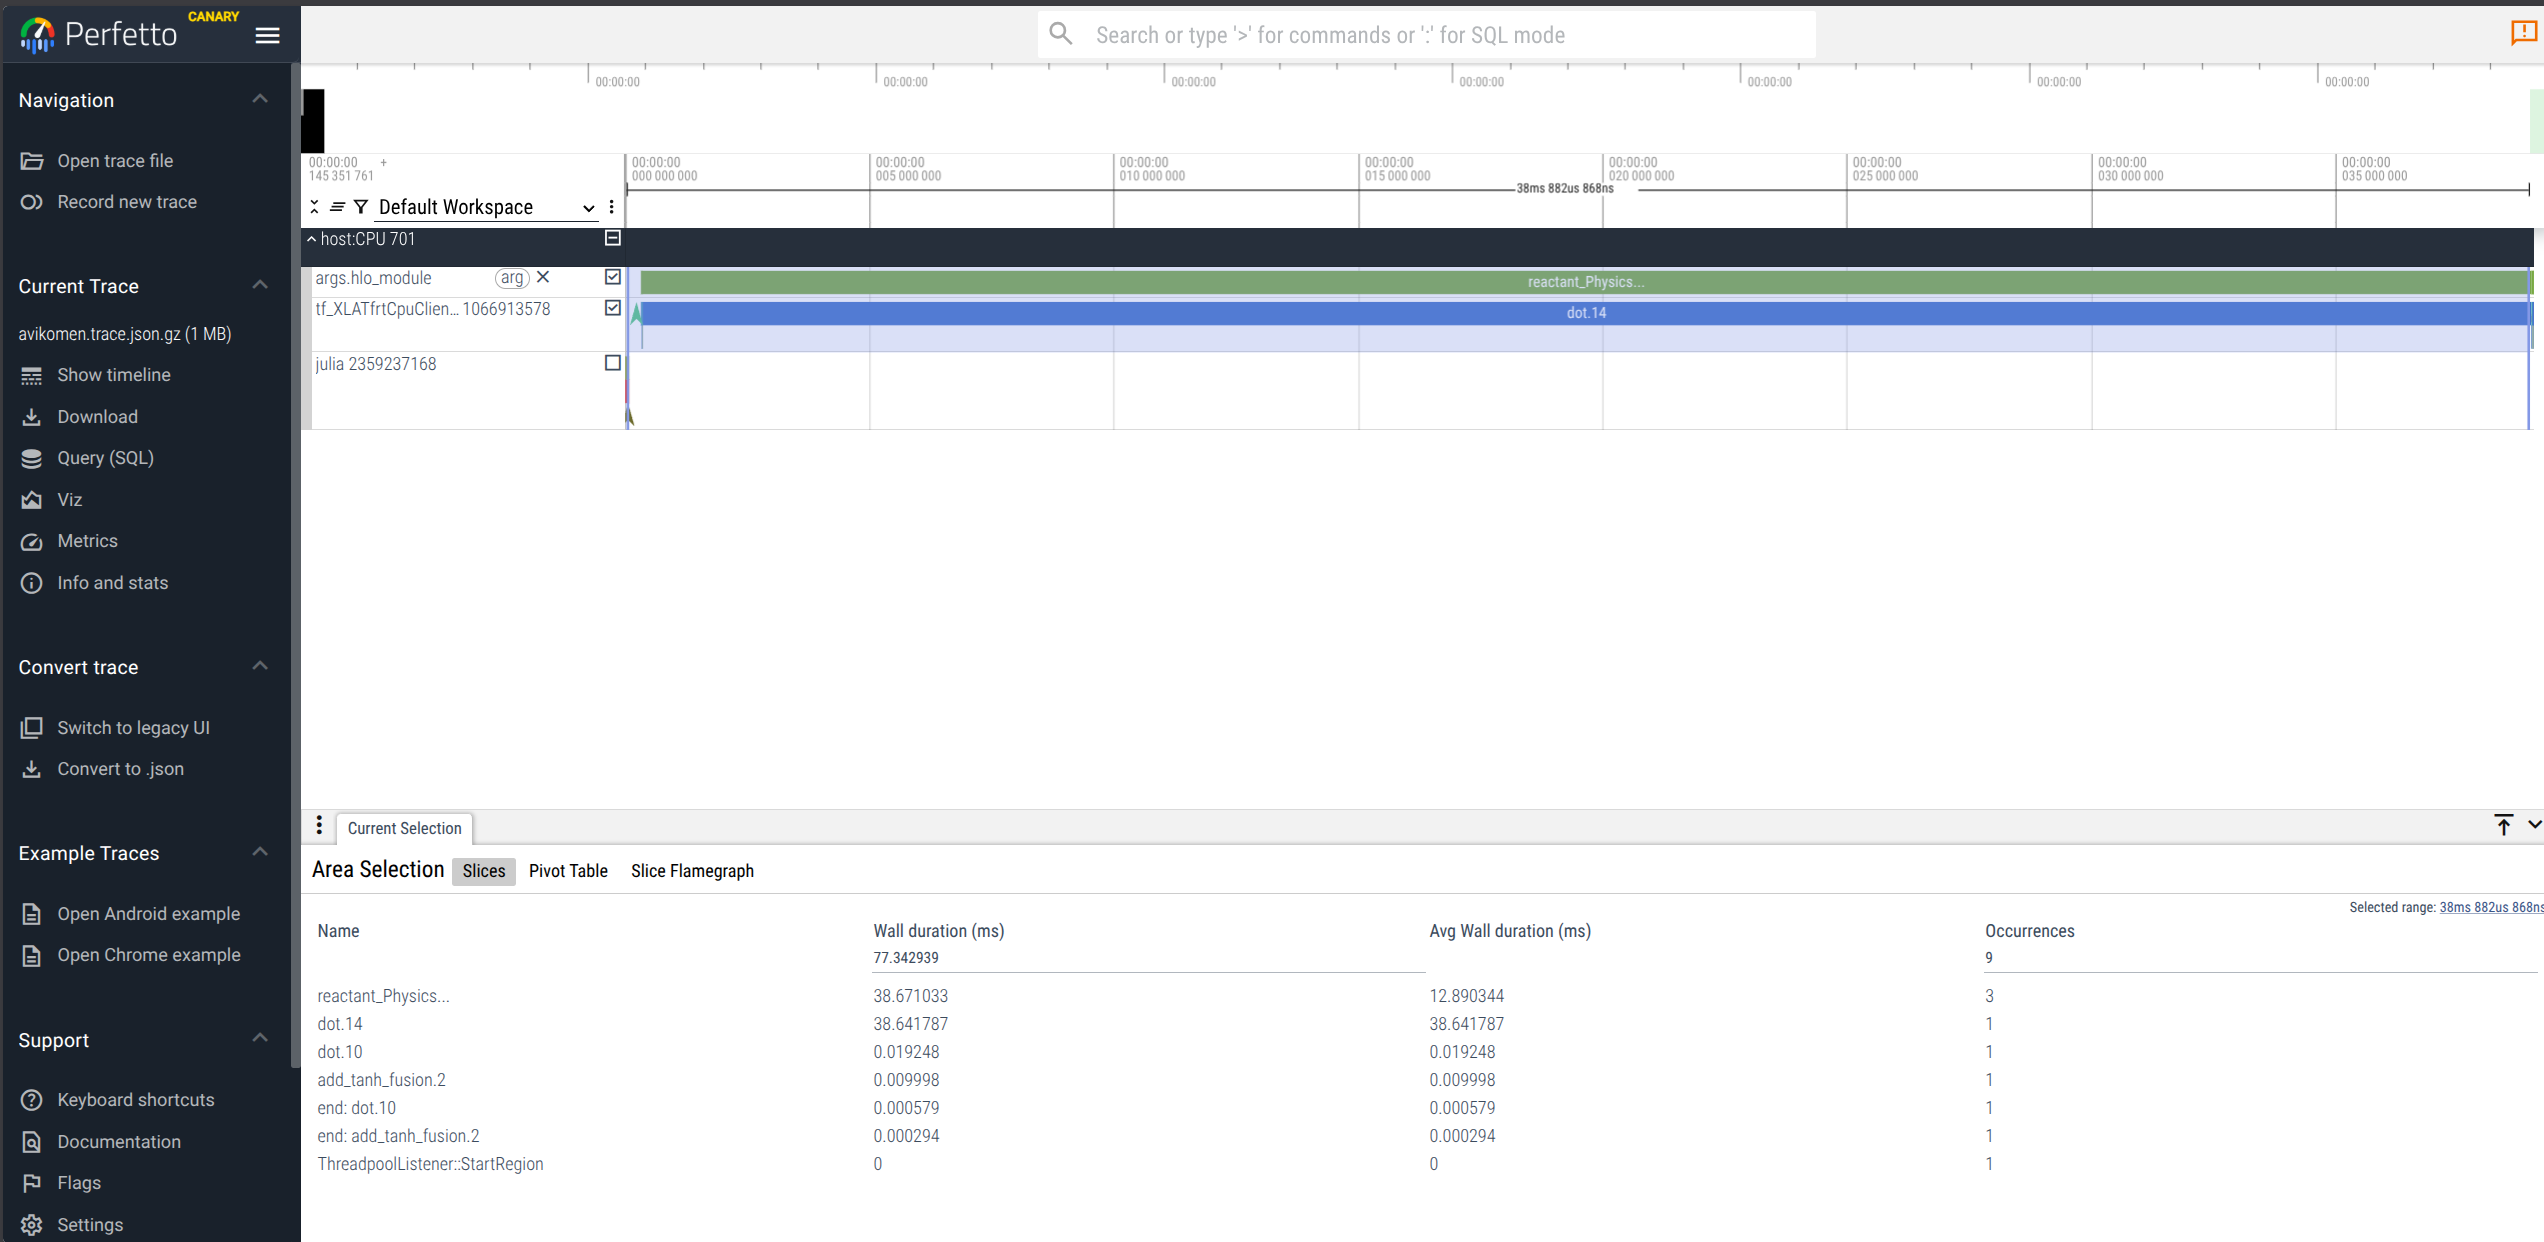

You can also visualize the graph using https://huggingface.co/spaces/google/model-explorer

In [22]:
hlo = @code_hlo pinn(xyt_ra, ps_ra, st_ra)
write("pinn.mlir", repr(hlo))

1781

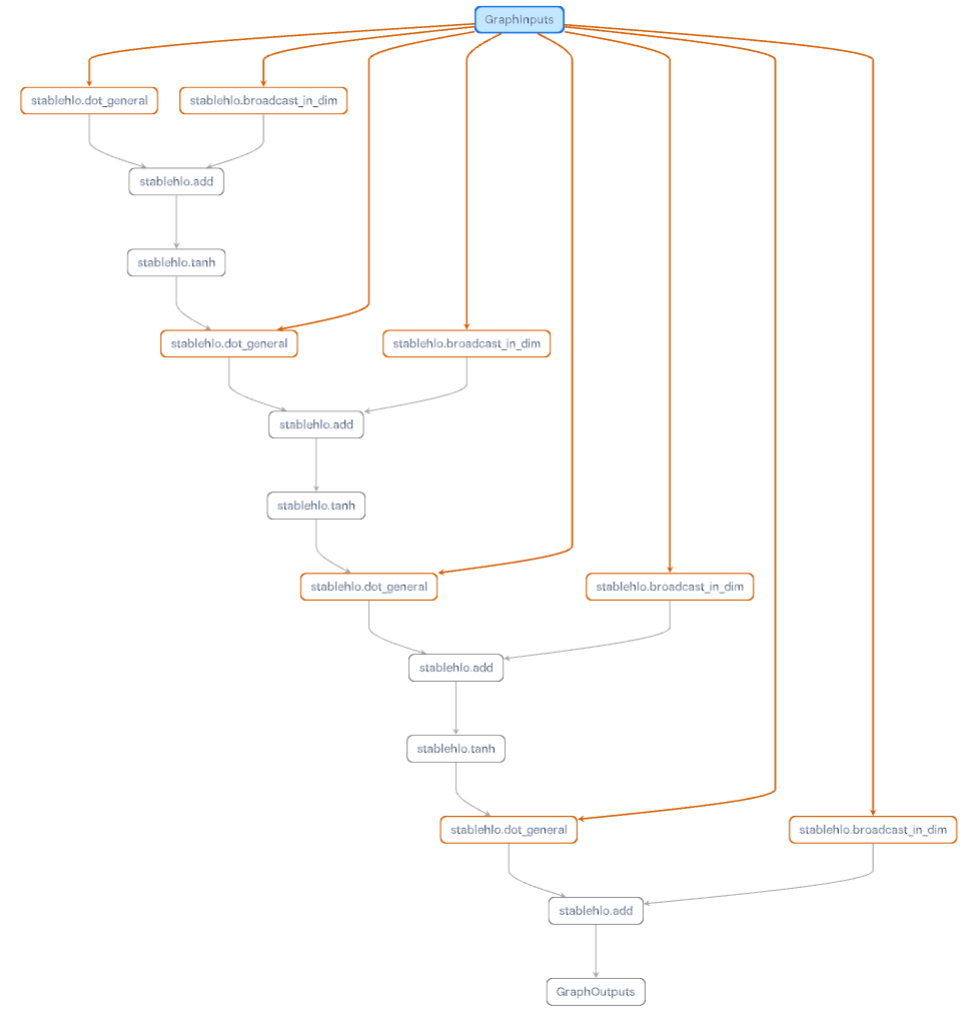

# Automatic Sharding Based Parallelism using Reactant

Inspired by: https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html

In [34]:
if !IS_COLAB_TPU
    # If you are not using tpu setup on Colab force using CPUs
    Reactant.set_default_backend("cpu")
end

In [36]:
Reactant.devices()

8-element Vector{Reactant.XLA.IFRT.Device}:
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002b7e98b0, "CPU:0 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002d50cc90, "CPU:1 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c744bb0, "CPU:2 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c7bda90, "CPU:3 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c08cf90, "CPU:4 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x00000000251deb10, "CPU:5 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002b6d28f0, "CPU:6 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002887f240, "CPU:7 cpu")

In [37]:
Reactant.addressable_devices()

8-element Vector{Reactant.XLA.IFRT.Device}:
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002b7e98b0, "CPU:0 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002d50cc90, "CPU:1 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c744bb0, "CPU:2 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c7bda90, "CPU:3 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002c08cf90, "CPU:4 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x00000000251deb10, "CPU:5 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002b6d28f0, "CPU:6 cpu")
 Reactant.XLA.IFRT.Device(Ptr{Nothing} @0x000000002887f240, "CPU:7 cpu")

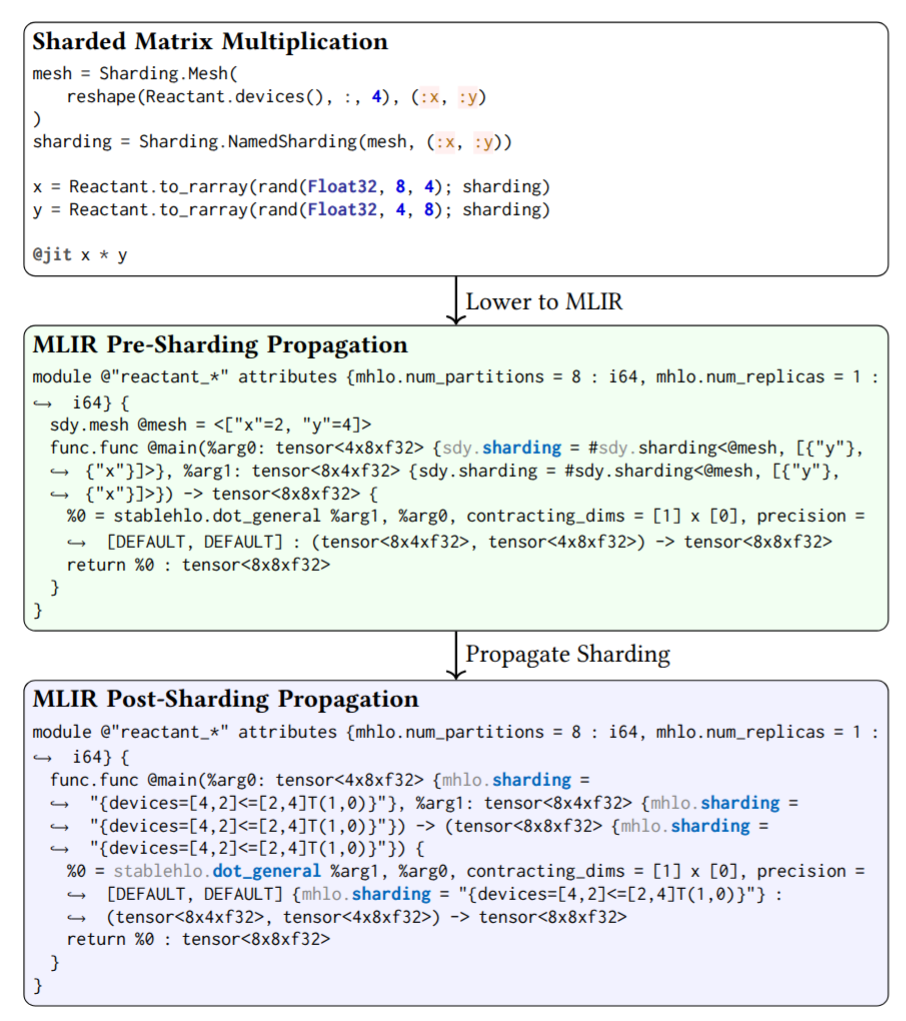

In [40]:
xy_mesh = Sharding.Mesh(
    reshape(Reactant.devices(), 2, 4),
    (:x, :y)
)

Reactant.Sharding.Mesh{2, Vector{Int64}}([0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], (:x, :y), (2, 4))

In [41]:
fn(x, y, z) = x .+ y .+ z

fn (generic function with 1 method)

In [42]:
x = Reactant.to_rarray(
    randn(Float32, 8, 8);
    sharding=Sharding.NamedSharding(xy_mesh, (:x, :y))
)

8×8 ConcreteIFRTArray{Float32,2} with "mhlo.sharding = {devices=[4,2]<=[2,4]T(1,0)}":
  0.0549777   0.343021    0.377337  …  -0.923881  -0.91361   -1.28276
  0.624117    0.940661    0.366364      1.26059   -0.159968   0.421372
  0.0127012   0.07777     0.99827       0.424171   1.77614    0.238797
 -0.846505    0.122391   -1.62568      -0.966275   2.70105   -0.566347
 -0.0716935  -0.677423   -0.552654     -0.785201   1.10412    0.0942265
  1.088      -0.712127    0.186202  …  -1.10039    0.160957  -0.0566135
  0.0410306   0.875403    0.797871     -0.919228   1.0026     0.025158
 -0.479069    0.0474298  -0.982449      1.77981   -0.693758  -0.846571

2025-04-27 14:58:54.434691: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


In [44]:
@code_hlo shardy_passes=:none fn(x, x, x)

module @reactant_fn attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) -> tensor<8x8xf32> {
    %0 = stablehlo.add %arg0, %arg0 : tensor<8x8xf32>
    %1 = stablehlo.add %0, %arg0 : tensor<8x8xf32>
    return %1 : tensor<8x8xf32>
  }
}

In [45]:
@code_hlo shardy_passes=:post_sdy_propagation fn(x, x, x)

module @reactant_fn attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) -> (tensor<8x8xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) {
    %0 = stablehlo.add %arg0, %arg0 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf32>
    %1 = stablehlo.add %0, %arg0 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf32>
    return %1 : tensor<8x8xf32>
  }
}

In [47]:
@jit fn(x, x, x)  # `mhlo.sharding` is same as that of `x`

2025-04-27 15:04:29.570589: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


8×8 ConcreteIFRTArray{Float32,2} with "mhlo.sharding = {devices=[4,2]<=[2,4]T(1,0)}":
  0.164933    1.02906    1.13201   …  -2.77164  -2.74083   -3.84827
  1.87235     2.82198    1.09909       3.78178  -0.479904   1.26411
  0.0381037   0.23331    2.99481       1.27251   5.32842    0.716392
 -2.53952     0.367173  -4.87703      -2.89882   8.10314   -1.69904
 -0.21508    -2.03227   -1.65796      -2.3556    3.31236    0.28268
  3.264      -2.13638    0.558606  …  -3.30118   0.482871  -0.169841
  0.123092    2.62621    2.39361      -2.75768   3.00781    0.0754739
 -1.43721     0.142289  -2.94735       5.33944  -2.08127   -2.53971

2025-04-27 15:04:29.670156: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


In [49]:
x_not_sharding = Reactant.to_rarray(Array(x)) # See no `mhlo.sharding` in the printed array

2025-04-27 15:05:40.704084: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


8×8 ConcreteIFRTArray{Float32,2}:
  0.0549777   0.343021    0.377337  …  -0.923881  -0.91361   -1.28276
  0.624117    0.940661    0.366364      1.26059   -0.159968   0.421372
  0.0127012   0.07777     0.99827       0.424171   1.77614    0.238797
 -0.846505    0.122391   -1.62568      -0.966275   2.70105   -0.566347
 -0.0716935  -0.677423   -0.552654     -0.785201   1.10412    0.0942265
  1.088      -0.712127    0.186202  …  -1.10039    0.160957  -0.0566135
  0.0410306   0.875403    0.797871     -0.919228   1.0026     0.025158
 -0.479069    0.0474298  -0.982449      1.77981   -0.693758  -0.846571

In [50]:
@jit(fn(x, x, x)) ≈ @jit(fn(x_not_sharding, x_not_sharding, x_not_sharding))

2025-04-27 15:06:17.837666: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.
2025-04-27 15:06:20.437680: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


true

## Example Usage with Lux

In [74]:
model = Chain(
    Conv((5, 5), 1 => 6, relu; cross_correlation=true),
    MaxPool((2, 2)),
    Conv((5, 5), 6 => 16, relu; cross_correlation=true),
    MaxPool((2, 2)),
    FlattenLayer(3),
    Chain(Dense(256 => 128, relu), Dense(128 => 84, relu), Dense(84 => 10)),
)

Chain(
    layer_1 = Conv((5, 5), 1 => 6, relu, cross_correlation=true),  # 156 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Conv((5, 5), 6 => 16, relu, cross_correlation=true),  # 2_416 parameters
    layer_4 = MaxPool((2, 2)),
    layer_5 = FlattenLayer{Static.StaticInt{3}}(static(3)),
    layer_6 = Chain(
        layer_1 = Dense(256 => 128, relu),  # 32_896 parameters
        layer_2 = Dense(128 => 84, relu),  # 10_836 parameters
        layer_3 = Dense(84 => 10),      # 850 parameters
    ),
)         # Total: 47_154 parameters,
          #        plus 0 states.

In [75]:
ps, st = Lux.setup(Random.default_rng(), model);

In [76]:
data = randn(Float32, 28, 28, 1, 32);

### Strategy 1: 8 way Batch Parallelism

In [77]:
batch_mesh = Sharding.Mesh(
    reshape(Reactant.devices(), 8),
    (:batch,)
)

Reactant.Sharding.Mesh{1, Vector{Int64}}([0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], (:batch,), (8,))

In [78]:
ps_batch, st_batch = (ps, st) |> ReactantDevice(; sharding = Sharding.Replicated(batch_mesh));

In [79]:
summary(ps_batch.layer_1.weight)  # replicated sharding across all the 8 devices

"5×5×1×6 ConcreteIFRTArray{Float32,4} with \"mhlo.sharding = {replicated}\""

In [80]:
data_batch = data |> ReactantDevice(; sharding = Sharding.DimsSharding(batch_mesh, (-1,), (:batch,)));

In [81]:
summary(data_batch)

"28×28×1×32 ConcreteIFRTArray{Float32,4} with \"mhlo.sharding = {devices=[8,1,1,1]<=[8]}\""

In [82]:
@code_hlo shardy_passes=:none model(
    data_batch,
    ps_batch,
    st_batch
)

module @"reactant_Chain{@..." attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["batch"=8]>
  func.func @main(%arg0: tensor<32x1x28x28xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"batch"}, {}, {}, {}]>}, %arg1: tensor<6x1x5x5xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {}]>}, %arg2: tensor<6xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg3: tensor<16x6x5x5xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {}]>}, %arg4: tensor<16xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg5: tensor<256x128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg6: tensor<128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg7: tensor<128x84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg8: tensor<84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg9: tensor<84x10xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg10: tensor<10xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}) -> tensor<32x10xf32> 

In [83]:
@code_hlo shardy_passes=:post_sdy_propagation model(
    data_batch,
    ps_batch,
    st_batch
)

module @"reactant_Chain{@..." attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["batch"=8]>
  func.func @main(%arg0: tensor<32x1x28x28xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"batch"}, {}, {}, {}]>}, %arg1: tensor<6x1x5x5xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {}]>}, %arg2: tensor<6xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg3: tensor<16x6x5x5xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {}]>}, %arg4: tensor<16xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg5: tensor<256x128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg6: tensor<128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg7: tensor<128x84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg8: tensor<84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}, %arg9: tensor<84x10xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}]>}, %arg10: tensor<10xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}]>}) -> (tensor<32x10xf32>

In [85]:
res, _ = @jit shardy_passes=:post_sdy_propagation model(
    data_batch,
    ps_batch,
    st_batch
)
summary(res) # sharded along the batch dimension

2025-04-27 15:18:57.789988: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:18:57.795089: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


"10×32 ConcreteIFRTArray{Float32,2} with \"mhlo.sharding = {devices=[8,1]<=[8]}\""

### Strategy 2: 4 way Batch Parallelism & 2 way Model Parallelism

In [86]:
batch_model_mesh = Sharding.Mesh(
    reshape(Reactant.devices(), 4, 2),
    (:batch, :model)
)

Reactant.Sharding.Mesh{2, Vector{Int64}}([0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], (:batch, :model), (4, 2))

In [90]:
ps_model, st_model = (ps, st) |> ReactantDevice(; sharding = Sharding.DimsSharding(batch_model_mesh, (1,), (:model,)));

In [93]:
summary(ps_model.layer_1.weight)  # replicated sharding across all the 8 devices

"5×5×1×6 ConcreteIFRTArray{Float32,4} with \"mhlo.sharding = {devices=[1,1,1,2,4]<=[4,2]T(1,0) last_tile_dim_replicate}\""

In [96]:
ps_model.layer_1.weight.padding

(1, 0, 0, 0)

In [101]:
data_model = data |> ReactantDevice(; sharding = Sharding.DimsSharding(batch_model_mesh, (-1,), (:batch,)));

In [102]:
summary(data_model)

"28×28×1×32 ConcreteIFRTArray{Float32,4} with \"mhlo.sharding = {devices=[4,1,1,1,2]<=[8] last_tile_dim_replicate}\""

In [103]:
@code_hlo shardy_passes=:post_sdy_propagation model(
    data_model,
    ps_model,
    st_model
)

module @"reactant_Chain{@..." attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["batch"=4, "model"=2]>
  func.func @main(%arg0: tensor<32x1x28x28xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"batch"}, {}, {}, {}]>}, %arg1: tensor<6x1x5x6xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {"model"}]>, tf.aliasing_output = 1 : i32}, %arg2: tensor<6xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"model"}]>}, %arg3: tensor<16x6x5x6xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {}, {}, {"model"}]>, tf.aliasing_output = 2 : i32}, %arg4: tensor<16xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"model"}]>}, %arg5: tensor<256x128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {"model"}]>}, %arg6: tensor<128xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"model"}]>}, %arg7: tensor<128x84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{}, {"model"}]>}, %arg8: tensor<84xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"model"}]>}, %arg9: tensor<84x10xf32> {sdy.shardi

In [105]:
res, _ = @jit model(
    data_model,
    ps_model,
    st_model
)
summary(res) # sharded along the batch dimension

2025-04-27 15:27:07.510652: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


"10×32 ConcreteIFRTArray{Float32,2} with \"mhlo.sharding = {devices=[4,2]<=[8]}\""

In [115]:
fn1(x, y, z) = (x .+ y) .+ z
fn2(x, y, z) = x .+ (y .+ z)

x_ra = Reactant.to_rarray(rand(8, 8); sharding=Sharding.NamedSharding(xy_mesh, (:x, :y)))
y_ra = Reactant.to_rarray(rand(8, 8); sharding=Sharding.NamedSharding(xy_mesh, (:x, :y)))
z_ra = Reactant.to_rarray(rand(8, 8); sharding=Sharding.NamedSharding(xy_mesh, (:y, :x)))
nothing

In [120]:
@code_hlo shardy_passes=:post_sdy_propagation optimize_communications=false fn1(x_ra, y_ra, z_ra)

module @reactant_fn1 attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg1: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg2: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"x"}, {"y"}]>}) -> tensor<8x8xf64> {
    %0 = stablehlo.add %arg0, %arg1 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    %1 = stablehlo.add %0, %arg2 : tensor<8x8xf64>
    return %1 : tensor<8x8xf64>
  }
}

In [121]:
@code_xla shardy_passes=:post_sdy_propagation optimize_communications=false fn1(x_ra, y_ra, z_ra)

2025-04-27 15:38:25.170811: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:38:25.189959: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_fn1, is_scheduled=true, entry_computation_layout={(f64[2,4]{1,0}, f64[2,4]{1,0}, f64[4,2]{1,0})->f64[8,8]{1,0}}, num_partitions=8

%fused_computation (param_0.1: f64[2,4], param_1.2: f64[2,4]) -> f64[2,4] {
  %param_1.2 = f64[2,4]{1,0} parameter(1)
  %copy.6 = f64[2,4]{0,1} copy(%param_1.2), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg1 (path=(:args, 1))"}
  %param_0.1 = f64[2,4]{1,0} parameter(0)
  %copy.5 = f64[2,4]{0,1} copy(%param_0.1), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg2 (path=(:args, 2))"}
  ROOT %add.6 = f64[2,4]{0,1} add(%copy.6, %copy.5), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
}

ENTRY %main.0_spmd (param: f64[2,4], param.1: f64[2,4], param.2: f64[4,2]) -> f64[8,8] {
  %param = f64[2,4]{1,0} parameter(0), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg1 (path=(:args, 1))"}
  %param.1 = f64[2,4]{1,0} parameter(1), sharding={devices=[4,2]<=[2,4]T(

In [119]:
@code_hlo shardy_passes=:post_sdy_propagation optimize_communications=false fn2(x_ra, y_ra, z_ra)

module @reactant_fn2 attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg1: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg2: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"x"}, {"y"}]>}) -> (tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) {
    %0 = stablehlo.add %arg1, %arg2 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    %1 = stablehlo.add %arg0, %0 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    return %1 : tensor<8x8xf64>
  }
}

In [122]:
@code_xla shardy_passes=:post_sdy_propagation optimize_communications=false fn2(x_ra, y_ra, z_ra)

2025-04-27 15:38:40.320965: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:38:40.325090: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_fn2, is_scheduled=true, entry_computation_layout={(f64[2,4]{1,0}, f64[2,4]{1,0}, f64[4,2]{1,0})->f64[2,4]{1,0}}, num_partitions=8

%fused_computation (param_0: f64[2,4], param_1.1: f64[2,4], param_2: f64[2,4]) -> f64[2,4] {
  %param_0 = f64[2,4]{1,0} parameter(0)
  %param_1.1 = f64[2,4]{1,0} parameter(1)
  %param_2 = f64[2,4]{1,0} parameter(2)
  %add.7 = f64[2,4]{1,0} add(%param_1.1, %param_2), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
  ROOT %add.6 = f64[2,4]{1,0} add(%param_0, %add.7), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
}

%fused_computation.1 (param_0.4: f64[1,2,2], param_1.2: f64[1,2,2]) -> f64[2,4] {
  %param_0.4 = f64[1,2,2]{2,1,0} parameter(0)
  %param_1.2 = f64[1,2,2]{2,1,0} parameter(1)
  %concatenate.1 = f64[2,2,2]{2,1,0} concatenate(%param_0.4, %param_1.2), dimensions={0}, metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/

In [116]:
@code_hlo shardy_passes=:post_sdy_propagation optimize_communications=true fn1(x_ra, y_ra, z_ra)

module @reactant_fn1 attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg1: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg2: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"x"}, {"y"}]>}) -> tensor<8x8xf64> {
    %0 = stablehlo.add %arg0, %arg1 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    %1 = stablehlo.add %0, %arg2 : tensor<8x8xf64>
    return %1 : tensor<8x8xf64>
  }
}

In [123]:
@code_xla shardy_passes=:post_sdy_propagation optimize_communications=true fn1(x_ra, y_ra, z_ra)

2025-04-27 15:39:00.454854: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:39:00.458452: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_fn1, is_scheduled=true, entry_computation_layout={(f64[2,4]{1,0}, f64[2,4]{1,0}, f64[4,2]{1,0})->f64[8,8]{1,0}}, num_partitions=8

%fused_computation (param_0.1: f64[2,4], param_1.2: f64[2,4]) -> f64[2,4] {
  %param_1.2 = f64[2,4]{1,0} parameter(1)
  %copy.6 = f64[2,4]{0,1} copy(%param_1.2), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg1 (path=(:args, 1))"}
  %param_0.1 = f64[2,4]{1,0} parameter(0)
  %copy.5 = f64[2,4]{0,1} copy(%param_0.1), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg2 (path=(:args, 2))"}
  ROOT %add.6 = f64[2,4]{0,1} add(%copy.6, %copy.5), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
}

ENTRY %main.0_spmd (param: f64[2,4], param.1: f64[2,4], param.2: f64[4,2]) -> f64[8,8] {
  %param = f64[2,4]{1,0} parameter(0), sharding={devices=[4,2]<=[2,4]T(1,0)}, metadata={op_name="arg1 (path=(:args, 1))"}
  %param.1 = f64[2,4]{1,0} parameter(1), sharding={devices=[4,2]<=[2,4]T(

In [117]:
@code_hlo shardy_passes=:post_sdy_propagation optimize_communications=true fn2(x_ra, y_ra, z_ra)

module @reactant_fn2 attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg1: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}, %arg2: tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"x"}, {"y"}]>}) -> (tensor<8x8xf64> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) {
    %0 = stablehlo.add %arg0, %arg1 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    %1 = stablehlo.add %0, %arg2 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : tensor<8x8xf64>
    return %1 : tensor<8x8xf64>
  }
}

In [124]:
@code_xla shardy_passes=:post_sdy_propagation optimize_communications=true fn2(x_ra, y_ra, z_ra)

2025-04-27 15:39:25.896558: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:39:25.900159: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_fn2, is_scheduled=true, entry_computation_layout={(f64[2,4]{1,0}, f64[2,4]{1,0}, f64[4,2]{1,0})->f64[2,4]{1,0}}, num_partitions=8

%fused_computation (param_0.1: f64[2,4], param_1.1: f64[2,4], param_2: f64[2,4]) -> f64[2,4] {
  %param_1.1 = f64[2,4]{1,0} parameter(1)
  %param_2 = f64[2,4]{1,0} parameter(2)
  %add.7 = f64[2,4]{1,0} add(%param_1.1, %param_2), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
  %param_0.1 = f64[2,4]{1,0} parameter(0)
  ROOT %add.6 = f64[2,4]{1,0} add(%add.7, %param_0.1), metadata={op_name="add" source_file="/mnt/software/lux/Reactant.jl/src/Ops.jl" source_line=373}
}

%fused_computation.1 (param_0.5: f64[1,2,2], param_1.2: f64[1,2,2]) -> f64[2,4] {
  %param_0.5 = f64[1,2,2]{2,1,0} parameter(0)
  %param_1.2 = f64[1,2,2]{2,1,0} parameter(1)
  %concatenate.1 = f64[2,2,2]{2,1,0} concatenate(%param_0.5, %param_1.2), dimensions={0}, metadata={op_name="add" source_file="/mnt/software/lux/Reactant.j

## Automatic Communication-Computation Balancing

In [129]:
function update_inplace!(x, y)
    x[6:(size(x, 1) - 15), :] = y
    return nothing
end

x_ra = Reactant.to_rarray(
    rand(Float32, 32, 24);
    sharding = Sharding.NamedSharding(xy_mesh, (:x, :y))
)

y_ra = Reactant.to_rarray(
    rand(Float32, 12, 24);
    sharding = Sharding.NamedSharding(xy_mesh, (:x, :y))
);

In [132]:
@code_hlo optimize_communications=false shardy_passes=:post_sdy_propagation update_inplace!(x_ra, y_ra)

module @reactant_update_... attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<24x32xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>, tf.aliasing_output = 0 : i32}, %arg1: tensor<24x12xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) -> (tensor<24x32xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) {
    %0 = stablehlo.slice %arg0 [0:24, 0:5] {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : (tensor<24x32xf32>) -> tensor<24x5xf32>
    %1 = stablehlo.slice %arg0 [0:24, 17:32] {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : (tensor<24x32xf32>) -> tensor<24x15xf32>
    %2 = stablehlo.concatenate %0, %arg1, %1, dim = 1 {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : (tensor<24x5xf32>, tensor<24x12xf32>, tensor<24x15xf32>) -> tensor<24x32xf32>
    return %2 : tensor<24x32xf32>
  }
}

In [133]:
@code_xla optimize_communications=false update_inplace!(x_ra, y_ra)  # `all-to-all`s emitted -- extremely bad

2025-04-27 15:47:28.575470: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_update_..., is_scheduled=true, input_output_alias={ {}: (0, {}, may-alias) }, entry_computation_layout={(f32[6,16]{1,0}, f32[6,6]{1,0})->f32[6,16]{1,0}}, num_partitions=8

%fused_computation (param_0.3: f32[1,3,1,16], param_1: f32[1,3,1,16]) -> f32[6,16] {
  %param_0.3 = f32[1,3,1,16]{3,2,1,0} parameter(0)
  %param_1 = f32[1,3,1,16]{3,2,1,0} parameter(1)
  %concatenate.7 = f32[1,3,2,16]{3,2,1,0} concatenate(%param_0.3, %param_1), dimensions={2}
  %transpose.4 = f32[1,2,3,16]{3,1,2,0} transpose(%concatenate.7), dimensions={0,2,1,3}
  %copy.6 = f32[1,2,3,16]{3,2,1,0} copy(%transpose.4)
  ROOT %bitcast.12 = f32[6,16]{1,0} bitcast(%copy.6)
}

%fused_computation.1 (param_0.5: f32[3,32]) -> f32[1,3,1,16] {
  %param_0.5 = f32[3,32]{1,0} parameter(0)
  %bitcast.13 = f32[1,3,2,16]{3,2,1,0} bitcast(%param_0.5)
  ROOT %slice.16 = f32[1,3,1,16]{3,2,1,0} slice(%bitcast.13), slice={[0:1], [0:3], [1:2], [0:16]}
}

%fused_computation.2 (param_0.7: f32[3,32]) -> f32[1,3,1,16] {
  %pa

In [134]:
@code_hlo optimize_communications=true shardy_passes=:post_sdy_propagation update_inplace!(x_ra, y_ra)

module @reactant_update_... attributes {mhlo.num_partitions = 8 : i64, mhlo.num_replicas = 1 : i64} {
  sdy.mesh @mesh = <["x"=2, "y"=4]>
  func.func @main(%arg0: tensor<24x32xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>, tf.aliasing_output = 0 : i32}, %arg1: tensor<24x12xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) -> (tensor<24x32xf32> {sdy.sharding = #sdy.sharding<@mesh, [{"y"}, {"x"}]>}) {
    %cst = stablehlo.constant {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} dense<0.000000e+00> : tensor<24x27xf32>
    %cst_0 = stablehlo.constant dense<1.000000e+00> : tensor<f32>
    %cst_1 = stablehlo.constant dense<0.000000e+00> : tensor<f32>
    %0 = stablehlo.slice %arg0 [0:24, 17:32] {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]>]>} : (tensor<24x32xf32>) -> tensor<24x15xf32>
    %1 = stablehlo.pad %arg1, %cst_1, low = [0, 0], high = [0, 15], interior = [0, 0] {sdy.sharding = #sdy.sharding_per_value<[<@mesh, [{"y"}, {"x"}]

In [135]:
@code_xla optimize_communications=true shardy_passes=:post_sdy_propagation update_inplace!(x_ra, y_ra) # No all-to-all s

2025-04-27 15:48:36.826710: I external/xla/xla/service/spmd/shardy/shardy_xla_pass.cc:315] Using Shardy for XLA SPMD propagation.
2025-04-27 15:48:36.830968: I external/xla/xla/hlo/utils/hlo_sharding_util.cc:3058] There is no registered layout_canonicalization_callback.


HloModule reactant_update_..., is_scheduled=true, input_output_alias={ {}: (0, {}, may-alias) }, entry_computation_layout={(f32[6,16]{1,0}, f32[6,6]{1,0})->f32[6,16]{1,0}}, num_partitions=8

%fused_computation (param_0.1: f32[6,3], param_1.4: f32[6,20], param_2.5: f32[6,22], param_3.8: u32[], param_4.7: f32[6,16]) -> f32[6,16] {
  %param_4.7 = f32[6,16]{1,0} parameter(4)
  %constant.58 = f32[24,32]{1,0} constant({...})
  %constant.57 = s32[8]{0} constant({0, 6, 12, 18, 0, 6, 12, 18})
  %param_3.8 = u32[] parameter(3)
  %dynamic-slice.21 = s32[1]{0} dynamic-slice(%constant.57, %param_3.8), dynamic_slice_sizes={1}
  %bitcast.14 = s32[] bitcast(%dynamic-slice.21)
  %constant.56 = s32[8]{0} constant({0, 0, 0, 0, 16, 16, 16, 16})
  %dynamic-slice.20 = s32[1]{0} dynamic-slice(%constant.56, %param_3.8), dynamic_slice_sizes={1}
  %bitcast.13 = s32[] bitcast(%dynamic-slice.20)
  %dynamic-slice.19 = f32[6,16]{1,0} dynamic-slice(%constant.58, %bitcast.14, %bitcast.13), dynamic_slice_sizes={6,16}


### Some Scaling Applications

- Scaling Ocean Simulations to several nodes: https://github.com/PRONTOLab/GB-25/tree/main

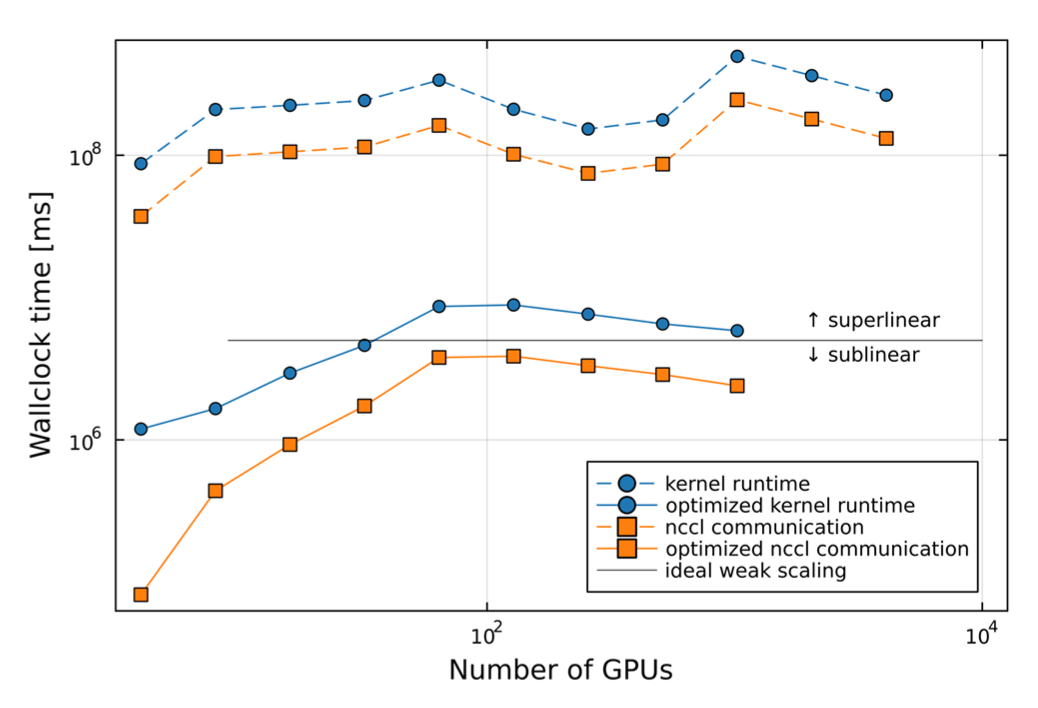

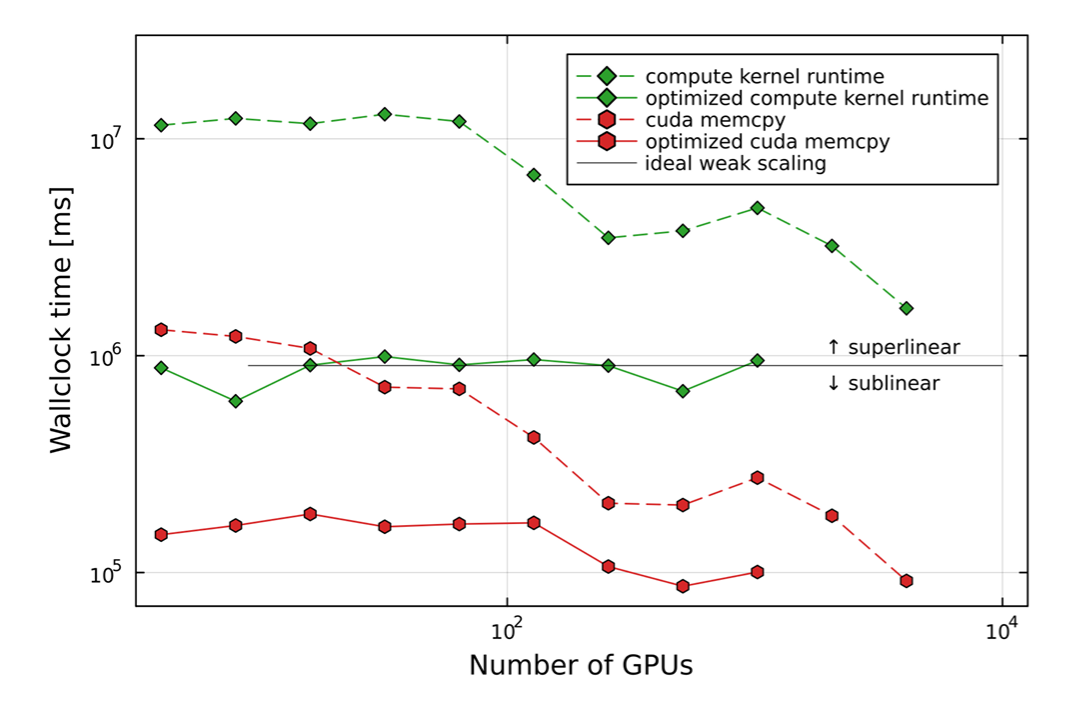